# NLP

---

## Analisis Keluhan Pelanggan Mobil Menggunakan NLP dan Artificial Neural Network untuk Klasifikasi Komponen Bermasalah

---

### 1. Identitas Kelompok

- **Nama Anggota:** Hafiz Alfariz, Fhad Saleh, Bagus, Rivaldi Revin
- **Batch:** RMT 045
- **Kelompok:** 01

---

### 2. Latar Belakang

Keluhan pelanggan mobil dari berbagai brand dan model sering kali ditulis dalam bentuk teks bebas dan label komponen yang tidak seragam. Hal ini membuat analisis manual menjadi tidak efisien, rentan bias, dan sulit untuk di-scale. Dengan pendekatan Natural Language Processing (NLP) dan Artificial Neural Network (ANN), analisis otomatis dapat membantu mengidentifikasi pola masalah utama dan melakukan klasifikasi komponen bermasalah secara lebih akurat dan konsisten. Penyeragaman label serta penggunaan seluruh data keluhan mobil dilakukan agar hasil analisis lebih komprehensif dan actionable untuk perbaikan produk dan layanan pabrikan otomotif.

---

### 3. Dataset

- **Sumber:** Kaggle - NHTSA Complaints
- **Deskripsi:** Dataset berisi data keluhan pelanggan dari berbagai brand dan model mobil, dengan fitur utama berupa kolom `summary` (teks keluhan) dan target `components` (komponen mobil yang dikeluhkan).
- **File:** `complaints.csv`

---

### 4. Objective

Membangun model Artificial Neural Network (ANN) berbasis NLP untuk mengklasifikasikan komponen mobil yang paling sering dikeluhkan berdasarkan teks keluhan pelanggan, dengan penyeragaman label komponen agar analisis lebih spesifik, relevan, dan mudah diinterpretasi.

---

### 5. Tujuan Proyek

1. **Menggunakan seluruh data keluhan pelanggan mobil** sebagai fokus analisis agar hasil lebih komprehensif.
2. **Menyeragamkan label pada kolom `components`** dengan mengelompokkan berbagai istilah menjadi satu label utama, sehingga target klasifikasi menjadi lebih jelas dan konsisten.
3. **Melakukan eksplorasi data** untuk memahami distribusi keluhan, tren komponen bermasalah, serta pola-pola penting lain yang muncul dari data.
4. **Melakukan preprocessing data teks keluhan (`summary`)** secara modular, meliputi cleaning, tokenizing, stopwords removal, dan seleksi fitur, dengan tetap mempertahankan istilah teknis otomotif yang penting.
5. **Mengonversi target ke bentuk numerik** yang sesuai untuk kebutuhan klasifikasi multi-class.
6. **Membangun dan melatih model ANN berbasis LSTM/GRU** dengan transfer learning embedding (Dolma/GloVe) untuk analisis keluhan berbasis teks.
7. **Melakukan evaluasi model** menggunakan metrik klasifikasi yang relevan (confusion matrix, accuracy, F1-score, analisis overfit/underfit).
8. **Melakukan hyperparameter tuning dan improvement model** (callback, dropout, batch normalization, transfer learning, augmentasi data minor class, dan class weighting).
9. **Menyimpan model terbaik** dan menyiapkan interface inference untuk prediksi data keluhan baru.
10. **Mendokumentasikan seluruh proses secara naratif** agar mudah dipahami oleh stakeholder teknis maupun non-teknis.

---

### 6. Ruang Lingkup

Seluruh proses dilakukan secara end-to-end mulai dari data mentah, preprocessing, eksplorasi, modeling, evaluasi, hingga deployment model. Hasil akhir diharapkan dapat membantu produsen otomotif dalam mengidentifikasi dan memprioritaskan perbaikan pada komponen yang paling sering dikeluhkan pelanggan secara otomatis dan berbasis data.

---

# 2. Import Libraries.

In [1]:
# 2. Import Libraries.

# --- NLTK & NLP Augmentation ---
import nltk
from nltk.tag import perceptron
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

# --- Data Manipulation & Visualization ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px

# --- Machine Learning & Deep Learning ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, Dense, Dropout, BatchNormalization,
    SpatialDropout1D, Bidirectional
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# --- Utilities ---
import re
import string
import warnings
warnings.filterwarnings('ignore')
import pickle
import json
from collections import Counter
from tqdm import tqdm
import random
from pathlib import Path

# 3. Data Loading

> Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut. Proses Data Loading dapat berupa memberi nama baru untuk setiap kolom, mengecek ukuran dataset, dll.

## 3.1 Load Dataset.

In [2]:
# Load complaints.csv into a DataFrame
df = pd.read_csv('complaints.csv')
df.head()

odiNumber                manufacturer  crash   fire  numberOfInjuries  \
0   10702705           Kia America, Inc.   True  False                 0   
1   10713088           Kia America, Inc.  False  False                 0   
2   10713503    ALUMA TOWER COMPANY, INC  False   True                 0   
3   10715078           Kia America, Inc.  False  False                 0   
4   10715844  Volvo Trucks North America  False  False                 0   

   numberOfDeaths dateOfIncident dateComplaintFiled          vin  \
0               0     03/24/2015         03/30/2015  5XYPG4A36GG   
1               0     04/24/2015         04/27/2015  5XYPH4A15GG   
2               0     04/28/2015         04/29/2015  1YGAE1629GB   
3               0     04/30/2015         05/07/2015          NaN   
4               0     03/06/2015         05/12/2015  4V4NC9EH7GN   

          components                                            summary  \
0   SEAT BELTS,SEATS        SEAT BELT DID NOT UNLATCH AFTER CRASH.  *TR   
1          STRUCTURE  TRAVELING AT HIGHWAY SPEED, THE WINDSHIELD SEE...   
2  ELECTRICAL SYSTEM  TL* THE CONTACT OWNS A 2016 ALUMA AE716TA TRAI...   
3           STEERING  WHILE TRAVELING AT HIGHWAY SPEEDS, THE SORENTO...   
4         SUSPENSION  SINCE THE PURCHASE OF THIS VEHICLE IT HAS AN U...   

                                            products   make    model  \
0  [{"type": "Vehicle", "productYear": "2016", "p...    KIA  SORENTO   
1  [{"type": "Vehicle", "productYear": "2016", "p...    KIA  SORENTO   
2  [{"type": "Vehicle", "productYear": "2016", "p...  ALUMA  AE716TA   
3  [{"type": "Vehicle", "productYear": "2016", "p...    KIA  SORENTO   
4  [{"type": "Vehicle", "productYear": "2016", "p...  VOLVO      780   

   modelYear  
0       2016  
1       2016  
2       2016  
3       2016  
4       2016

Dari hasil `df.head()`, kita bisa melihat _raw data_ berisi beberapa kolom penting, di antaranya:

- `odiNumber`: ID keluhan.
- `manufacturer`: Nama produsen.
- `crash`, `fire`, `numberOfInjuries`, `numberOfDeaths`: Informasi terkait insiden.
- `dateOfIncident`, `dateComplaintFiled`: Tanggal kejadian dan tanggal keluhan.
- `vin`: Nomor identifikasi kendaraan.
- `components`: Komponen mobil yang dikeluhkan.
- `summary`: Teks keluhan pelanggan (kolom utama untuk analisis NLP).
- `make`, `model`, `modelYear`: Informasi tipe dan tahun mobil.


## 3.2 Dataset Dimensions.

In [3]:
print(f"Dataset memiliki {df.shape[0]} baris dan {df.shape[1]} kolom.")

Dataset memiliki 222336 baris dan 15 kolom.


## 3.3 Check Data Types.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222336 entries, 0 to 222335
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   odiNumber           222336 non-null  int64 
 1   manufacturer        222330 non-null  object
 2   crash               222336 non-null  bool  
 3   fire                222336 non-null  bool  
 4   numberOfInjuries    222336 non-null  int64 
 5   numberOfDeaths      222336 non-null  int64 
 6   dateOfIncident      222336 non-null  object
 7   dateComplaintFiled  222336 non-null  object
 8   vin                 217302 non-null  object
 9   components          222335 non-null  object
 10  summary             222325 non-null  object
 11  products            222336 non-null  object
 12  make                222336 non-null  object
 13  model               222336 non-null  object
 14  modelYear           222336 non-null  int64 
dtypes: bool(2), int64(4), object(9)
memory usage: 22.5+

In [5]:
# Ubah tipe data kolom tanggal menjadi datetime
df['dateOfIncident'] = pd.to_datetime(df['dateOfIncident'], errors='coerce')
df['dateComplaintFiled'] = pd.to_datetime(df['dateComplaintFiled'], errors='coerce')

# Ubah tipe data kolom modelYear menjadi integer (jika belum)
df['modelYear'] = pd.to_numeric(df['modelYear'], errors='coerce').astype('Int64')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222336 entries, 0 to 222335
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   odiNumber           222336 non-null  int64         
 1   manufacturer        222330 non-null  object        
 2   crash               222336 non-null  bool          
 3   fire                222336 non-null  bool          
 4   numberOfInjuries    222336 non-null  int64         
 5   numberOfDeaths      222336 non-null  int64         
 6   dateOfIncident      222336 non-null  datetime64[ns]
 7   dateComplaintFiled  222336 non-null  datetime64[ns]
 8   vin                 217302 non-null  object        
 9   components          222335 non-null  object        
 10  summary             222325 non-null  object        
 11  products            222336 non-null  object        
 12  make                222336 non-null  object        
 13  model               222336 no

Berdasarkan hasil `df.info()`, dataset keluhan mobil terdiri dari **222.336 baris dan 15 kolom**. Hampir semua kolom sudah memiliki tipe data yang sesuai, terutama kolom tanggal (`dateOfIncident` dan `dateComplaintFiled`) yang sudah bertipe `datetime64[ns]`, sehingga akan sangat membantu jika ingin melakukan analisis waktu. Kolom `modelYear` juga sudah bertipe integer (`Int64`), jadi tidak perlu dilakukan konversi lagi.

Sebagian besar kolom seperti `odiNumber`, `manufacturer`, `make`, dan `model` hanya berfungsi sebagai identitas atau penanda, sehingga tidak akan digunakan dalam modeling utama. Fokus utama analisis adalah pada kolom `summary` yang berisi teks keluhan pelanggan sebagai fitur utama untuk NLP, dan kolom `components` sebagai target klasifikasi yang ingin diprediksi.

Terdapat beberapa kolom yang bisa dipakai untuk analisis tambahan, seperti `crash`, `fire`, `numberOfInjuries`, dan `numberOfDeaths`. Namun, untuk model NLP, fokus tetap pada `summary` dan `components`. Satu-satunya kolom yang memiliki missing value cukup banyak adalah `vin`, namun kolom ini tidak relevan untuk modeling sehingga tidak menjadi masalah. Selain itu, kolom `manufacturer`, `components`, dan `summary` juga memiliki sedikit missing value, namun jumlahnya sangat kecil dibanding total data.

Secara keseluruhan, dataset ini sudah siap untuk tahap eksplorasi dan preprocessing selanjutnya.

## 3.4 Drop Multi-label pada Kolom Components

Pada tahap ini, baris data yang memiliki lebih dari satu label pada kolom `components` akan dihapus. Hal ini dilakukan karena setiap baris hanya boleh mewakili satu komponen utama yang dikeluhkan agar proses klasifikasi menjadi problem single-label (bukan multi-label). Jika satu baris memiliki beberapa komponen, model akan kesulitan dalam training dan evaluasi, serta hasil prediksi menjadi ambigu. Dengan hanya mempertahankan baris yang memiliki satu label, proses preprocessing, training, dan evaluasi model menjadi lebih sederhana, konsisten, dan sesuai dengan tujuan klasifikasi multi-class.

In [7]:
# Drop baris yang memiliki lebih dari satu label pada kolom 'components'
df = df[~df['components'].str.contains(',', na=False)]
print(f"Dataset setelah drop multi-label pada 'components': {df.shape[0]} baris")
print("Unique values in 'components':")
print(df['components'].unique())

Dataset setelah drop multi-label pada 'components': 151417 baris
Unique values in 'components':
['STRUCTURE' 'ELECTRICAL SYSTEM' 'STEERING' 'SUSPENSION'
 'VEHICLE SPEED CONTROL' 'VISIBILITY/WIPER' 'VISIBILITY' 'SERVICE BRAKES'
 'WHEELS' 'POWER TRAIN' 'UNKNOWN OR OTHER' 'FORWARD COLLISION AVOIDANCE'
 'SEATS' 'EXTERIOR LIGHTING' 'EQUIPMENT ADAPTIVE/MOBILITY' 'TIRES'
 'EQUIPMENT' 'AIR BAGS' 'ENGINE' 'SEAT BELTS' 'FUEL/PROPULSION SYSTEM'
 'ELECTRONIC STABILITY CONTROL (ESC)' 'ENGINE AND ENGINE COOLING'
 'BACK OVER PREVENTION' 'LATCHES/LOCKS/LINKAGES' 'LANE DEPARTURE'
 'PARKING BRAKE' 'CHILD SEAT' 'TRAILER HITCHES' 'INTERIOR LIGHTING'
 'TRACTION CONTROL SYSTEM' 'HYBRID PROPULSION SYSTEM'
 'Other/I am not sure' 'FIRERELATED' 'ELECTRONIC STABILITY CONTROL'
 'COMMUNICATIONS' 'COMMUNICATION' 'I suspect the car seat is counterfeit'
 'NONE' nan]


components
ENGINE                                   24557
UNKNOWN OR OTHER                         19069
POWER TRAIN                              18301
ELECTRICAL SYSTEM                        15278
STEERING                                  9847
SERVICE BRAKES                            9086
STRUCTURE                                 7332
VISIBILITY/WIPER                          7096
AIR BAGS                                  6214
FUEL/PROPULSION SYSTEM                    5691
FORWARD COLLISION AVOIDANCE               4106
ENGINE AND ENGINE COOLING                 4038
EXTERIOR LIGHTING                         3976
SUSPENSION                                2277
VEHICLE SPEED CONTROL                     2149
WHEELS                                    2113
SEAT BELTS                                1779
VISIBILITY                                1725
TIRES                                     1476
BACK OVER PREVENTION                      1472
SEATS                                     1295
LA

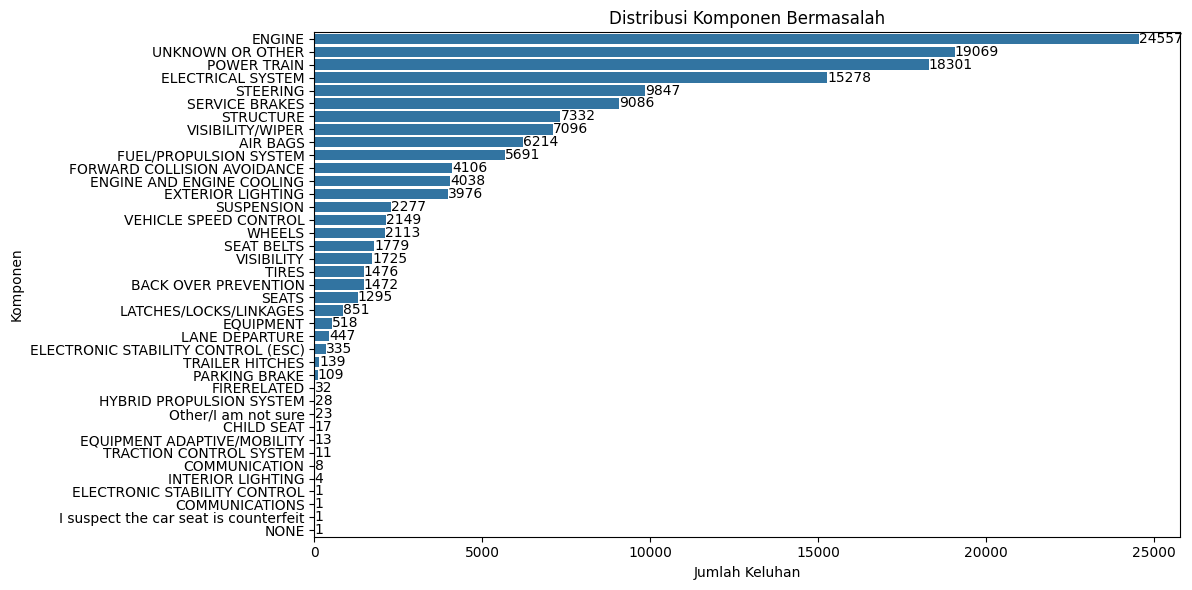

In [8]:
# Tampilkan jumlah keluhan per komponen
print(df['components'].value_counts())

# Visualisasi distribusi label (bar chart)
plt.figure(figsize=(12,6))
ax=sns.countplot(y='components', data=df, order=df['components'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.title('Distribusi Komponen Bermasalah')
plt.xlabel('Jumlah Keluhan')
plt.ylabel('Komponen')
plt.tight_layout()
plt.show()

## 3.5 Grouping Component

Pada tahap ini, dilakukan proses grouping atau pengelompokan kembali label pada kolom `components` menjadi kategori utama yang lebih sedikit dan lebih relevan. Hal ini penting karena pada data asli, label komponen sangat bervariasi dan banyak istilah yang sebenarnya merujuk pada masalah yang sama, namun ditulis dengan nama berbeda (misal: "ENGINE", "ENGINE AND ENGINE COOLING", "FIRERELATED", dll).

Jika label dibiarkan terlalu banyak dan tidak dikelompokkan, maka:
- Distribusi data menjadi sangat timpang, banyak label minoritas yang hanya muncul beberapa kali.
- Model klasifikasi akan kesulitan belajar pola pada label yang sangat jarang muncul, sehingga performa pada kelas minor sangat buruk.
- Interpretasi hasil analisis menjadi tidak jelas karena terlalu banyak kategori yang mirip atau tumpang tindih.

Dengan melakukan grouping, istilah-istilah yang mirip atau berkaitan digabung ke dalam satu kategori utama (misal: semua masalah mesin ke "ENGINE", semua masalah kelistrikan ke "ELECTRICAL", dll). Selain itu, label yang jumlahnya sangat sedikit (<10 kasus) juga digabungkan ke dalam kategori "OTHER" agar distribusi label lebih seimbang dan model tidak bias ke kelas mayoritas saja.

Langkah ini membuat data target menjadi lebih bersih, konsisten, dan siap untuk analisis serta training model klasifikasi multi-class yang lebih robust

In [9]:
# Fungsi untuk membersihkan dan mengelompokkan komponen

def clean_component(value):
    if pd.isnull(value):
        return "OTHER"
    value = str(value).upper().strip()

    # ENGINE & COOLING
    if value == "ENGINE":
        return "ENGINE"
    elif value == "ENGINE AND ENGINE COOLING":
        return "ENGINE COOLING"
    elif value == "FIRERELATED":
        return "ENGINE"

    # POWER TRAIN
    elif value == "POWER TRAIN":
        return "POWER TRAIN"

    # ELECTRICAL & COMMUNICATIONS
    elif value in ["ELECTRICAL SYSTEM", "COMMUNICATION", "COMMUNICATIONS"]:
        return "ELECTRICAL"

    # STEERING
    elif value == "STEERING":
        return "STEERING"

    # BRAKES
    elif value in ["SERVICE BRAKES", "PARKING BRAKE"]:
        return "BRAKES"

    # STRUCTURE/BODY
    elif (
        value == "STRUCTURE"
        or any(x in value for x in ["TRAILER HITCH", "TRAILER HITCHES"])
    ):
        return "STRUCTURE/BODY"

    # VISIBILITY & LIGHTING
    elif value in ["VISIBILITY/WIPER", "VISIBILITY", "EXTERIOR LIGHTING", "INTERIOR LIGHTING"]:
        return "VISIBILITY & LIGHTING"

    # RESTRAINTS & AIRBAGS
    elif value == "AIR BAGS":
        return "RESTRAINTS & AIRBAGS"
    elif value in ["SEAT BELTS", "SEATS", "LATCHES/LOCKS/LINKAGES", "CHILD SEAT"] or \
         any(x in value for x in ["CHEST CLIP", "BUCKLE", "HARNESS"]):
        return "RESTRAINTS & AIRBAGS"

    # WHEELS/TIRES/SUSPENSION
    elif value in ["WHEELS", "TIRES", "SUSPENSION"]:
        return "WHEELS/TIRES/SUSPENSION"

    # FUEL & PROPULSION
    elif value in ["FUEL/PROPULSION SYSTEM", "HYBRID PROPULSION SYSTEM"]:
        return "FUEL & PROPULSION"

    # ADAS & STABILITY
    elif value in [
        "VEHICLE SPEED CONTROL",
        "TRACTION CONTROL SYSTEM",
        "BACK OVER PREVENTION",
        "LANE DEPARTURE",
        "FORWARD COLLISION AVOIDANCE",
        "ELECTRONIC STABILITY CONTROL (ESC)",
        "ELECTRONIC STABILITY CONTROL",
    ]:
        return "ADAS & STABILITY"

    # EQUIPMENT / OTHER
    elif value in ["EQUIPMENT", "EQUIPMENT ADAPTIVE/MOBILITY"]:
        return "OTHER"
    elif value in ["UNKNOWN OR OTHER", "OTHER/I AM NOT SURE", "NONE", "I SUSPECT THE CAR SEAT IS COUNTERFEIT"]:
        return "OTHER"
    else:
        return "OTHER"

# Mapping komponen utama
df['components'] = df['components'].apply(clean_component)

# Gabungkan label minor (<10) ke OTHER
label_counts = df['components'].value_counts()
minor_labels = label_counts[label_counts < 10].index.tolist()
df['components'] = df['components'].apply(lambda x: 'OTHER' if x in minor_labels else x)

print("Unique values setelah grouping & minor label digabung:")
print(df['components'].unique())

Unique values setelah grouping & minor label digabung:
['STRUCTURE/BODY' 'ELECTRICAL' 'STEERING' 'WHEELS/TIRES/SUSPENSION'
 'ADAS & STABILITY' 'VISIBILITY & LIGHTING' 'BRAKES' 'POWER TRAIN' 'OTHER'
 'RESTRAINTS & AIRBAGS' 'ENGINE' 'FUEL & PROPULSION' 'ENGINE COOLING']


components
ENGINE                     24589
OTHER                      19626
POWER TRAIN                18301
ELECTRICAL                 15287
VISIBILITY & LIGHTING      12801
RESTRAINTS & AIRBAGS       10156
STEERING                    9847
BRAKES                      9195
ADAS & STABILITY            8521
STRUCTURE/BODY              7471
WHEELS/TIRES/SUSPENSION     5866
FUEL & PROPULSION           5719
ENGINE COOLING              4038
Name: count, dtype: int64


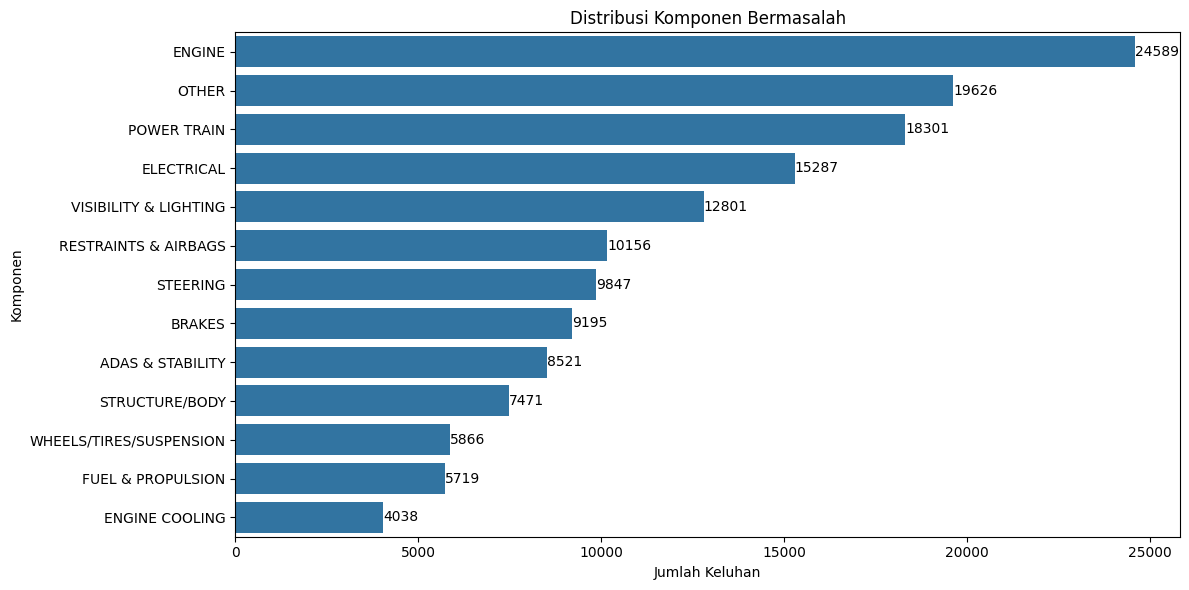

In [10]:
# Tampilkan jumlah keluhan per komponen
print(df['components'].value_counts())

# Visualisasi distribusi label (bar chart)
plt.figure(figsize=(12,6))
ax=sns.countplot(y='components', data=df, order=df['components'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.title('Distribusi Komponen Bermasalah')
plt.xlabel('Jumlah Keluhan')
plt.ylabel('Komponen')
plt.tight_layout()
plt.show()

Setelah melakukan proses penyeragaman label pada kolom `components`, berbagai istilah komponen yang mirip berhasil dikelompokkan ke dalam kategori utama, seperti **ENGINE**, **BRAKES**, **POWER TRAIN**, **ELECTRICAL**, dan lain-lain. Langkah ini sangat penting agar analisis dan pemodelan menjadi lebih fokus, tidak terpecah oleh variasi penamaan yang berbeda-beda, serta memudahkan interpretasi hasil di seluruh merek dan model mobil.

Selain itu, label minor yang jumlahnya kurang dari 10 kasus digabungkan ke dalam kategori **OTHER**. Strategi ini bertujuan untuk menyeimbangkan distribusi label, sehingga model klasifikasi yang dibangun tidak terlalu bias terhadap kelas-kelas yang sangat jarang muncul. Hasil grouping ini juga membuat jumlah kategori komponen menjadi lebih sedikit dan lebih relevan untuk kebutuhan klasifikasi multi-class.

Secara keseluruhan, proses penyeragaman dan penggabungan label minor ini membuat data target menjadi lebih bersih, konsisten, dan siap digunakan untuk analisis lebih lanjut maupun training model NLP. Dengan data yang sudah terstruktur, hasil model akan lebih mudah diinterpretasikan dan dapat memberikan insight yang lebih actionable untuk perbaikan produk dan layanan di berbagai manufaktur otomotif.

---

## 3.6 Check Duplicate & Missing Value

In [11]:
# Cek duplikasi
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())

# Cek missing values
print("Missing values per column:")
print(df.isnull().sum())


Number of duplicate rows:
0
Missing values per column:
odiNumber                0
manufacturer             4
crash                    0
fire                     0
numberOfInjuries         0
numberOfDeaths           0
dateOfIncident           0
dateComplaintFiled       0
vin                   3628
components               0
summary                  9
products                 0
make                     0
model                    0
modelYear                0
dtype: int64


## 3.7 Final Check Data

In [12]:
# Drop baris yang memiliki missing value pada kolom 'summary'
df = df.dropna(subset=['summary'])
print(f"Dataset setelah drop missing value pada 'summary': {df.shape[0]} baris")

# Cek missing values
print("Missing values per column:")
print(df.isnull().sum())

Dataset setelah drop missing value pada 'summary': 151408 baris
Missing values per column:
odiNumber                0
manufacturer             4
crash                    0
fire                     0
numberOfInjuries         0
numberOfDeaths           0
dateOfIncident           0
dateComplaintFiled       0
vin                   3628
components               0
summary                  0
products                 0
make                     0
model                    0
modelYear                0
dtype: int64


Pada tahap ini, hanya baris dengan missing value pada kolom `summary` yang dihapus. Hal ini dilakukan karena `summary` merupakan fitur utama (teks keluhan pelanggan) yang akan digunakan sebagai input dalam analisis NLP dan pemodelan klasifikasi. Tanpa data pada kolom ini, model tidak memiliki informasi yang bisa diproses.

Kolom `components` sendiri sudah di-handle pada tahap sebelumnya, baik untuk multi-label maupun penyeragaman label. Karena fokus utama analisis dan modeling adalah pada hubungan antara teks keluhan (`summary`) dan label komponen (`components`), maka kedua kolom ini wajib terisi. Kolom lain yang memiliki missing value tidak berpengaruh langsung terhadap proses klasifikasi, sehingga tidak perlu dihapus pada tahap ini.

Dengan demikian, proses ini memastikan hanya data yang benar-benar relevan dan lengkap untuk kebutuhan modeling yang dipertahankan.

# 4. EDA Prepocessing.

## 4.1 Statistik Deskriptif.

### 4.1.1 Menghitung panjang teks keluhan(`summary`).

In [13]:
# Menghitung jumlah data
print("Jumlah data:", len(df))

# Menghitung jumlah label unik pada kolom components
print("Jumlah label unik pada components:", df['components'].nunique())

Jumlah data: 151408
Jumlah label unik pada components: 13


Setelah proses pembersihan, jumlah data yang tersedia adalah **151.408 baris**, jumlah yang sangat memadai untuk membangun model klasifikasi berbasis NLP pada data keluhan pelanggan mobil dari berbagai manufaktur. Selain itu, jumlah label unik pada kolom `components` kini menjadi **13 kategori** yang sudah terstandarisasi. Dengan jumlah label yang lebih sedikit dan konsisten, proses pembangunan model menjadi lebih terarah untuk membedakan keluhan antar komponen secara akurat di seluruh merek dan model mobil, bukan hanya satu tipe saja.

Namun, distribusi masing-masing label tetap perlu diperhatikan agar tidak terjadi ketimpangan (imbalance) yang dapat mempengaruhi performa model, terutama pada kelas minoritas. Dengan data yang lebih bersih dan label yang sudah digabung, proses modeling dan analisis menjadi lebih efisien dan hasilnya lebih relevan untuk kebutuhan klasifikasi multi-class di industri otomotif secara umum.

### 4.1.2 Menghitung jumlah kata per keluhan.

In [14]:
# Menghitung panjang teks keluhan (jumlah kata per summary)
df['summary_length'] = df['summary'].apply(lambda x: len(str(x).split()))
print("Statistik panjang teks keluhan (jumlah kata per summary):")
print(df['summary_length'].describe())

Statistik panjang teks keluhan (jumlah kata per summary):
count    151408.000000
mean         95.195142
std          71.425128
min           1.000000
25%          45.000000
50%          80.000000
75%         123.000000
max         720.000000
Name: summary_length, dtype: float64


Berdasarkan statistik di atas, rata-rata panjang teks keluhan pelanggan adalah sekitar **95 kata** dengan standar deviasi sekitar **71 kata**. Nilai minimum hanya **1 kata**, sedangkan maksimum mencapai **720 kata**. Kuartil 25% berada di **45 kata**, median (50%) di **80 kata**, dan kuartil 75% di **123 kata**. Hal ini menunjukkan bahwa sebagian besar pelanggan menuliskan keluhan mereka dengan cukup detail, meskipun ada juga beberapa keluhan yang sangat singkat. Rentang jumlah kata yang cukup lebar ini mencerminkan variasi gaya penulisan dan tingkat kejelasan keluhan dari masing-masing pelanggan. Dengan data yang cukup panjang dan detail seperti ini, proses analisis dan modeling berbasis NLP memiliki potensi yang baik karena informasi yang tersedia sangat kaya.

### 4.1.3 Menghitung distribusi label pada kolom (`components`).

In [15]:
# Mengecek distribusi label pada kolom components
print("\nDistribusi label pada components:")
print(df['components'].value_counts())


Distribusi label pada components:
components
ENGINE                     24589
OTHER                      19621
POWER TRAIN                18301
ELECTRICAL                 15287
VISIBILITY & LIGHTING      12801
RESTRAINTS & AIRBAGS       10154
STEERING                    9847
BRAKES                      9194
ADAS & STABILITY            8521
STRUCTURE/BODY              7471
WHEELS/TIRES/SUSPENSION     5865
FUEL & PROPULSION           5719
ENGINE COOLING              4038
Name: count, dtype: int64


Berdasarkan distribusi label pada kolom `components`, keluhan pelanggan Ford Escape paling banyak berasal dari komponen **ENGINE** (24.589 kasus), diikuti oleh **OTHER** (19.621 kasus), **POWER TRAIN** (18.301 kasus), dan **ELECTRICAL** (15.287 kasus). Komponen seperti **VISIBILITY & LIGHTING**, **RESTRAINTS & AIRBAGS**, **STEERING**, dan **BRAKES** juga memiliki jumlah keluhan yang cukup signifikan. Sementara itu, kategori seperti **ENGINE COOLING** (4.038 kasus), **FUEL & PROPULSION** (5.719 kasus), dan **WHEELS/TIRES/SUSPENSION** (5.865 kasus) memiliki jumlah keluhan yang jauh lebih sedikit dibandingkan kelas mayoritas.

Distribusi ini menunjukkan adanya ketimpangan (imbalance) antar kelas yang cukup besar. Kondisi imbalance ini perlu menjadi perhatian khusus saat membangun model klasifikasi, agar prediksi tidak hanya fokus pada kelas mayoritas. Oleh karena itu, strategi seperti **data augmentation** dan **class weighting** sangat penting agar model tetap mampu mengenali kelas minoritas dengan baik. Analisis distribusi label ini juga membantu mengidentifikasi komponen yang paling sering bermasalah, sehingga rekomendasi perbaikan produk dapat lebih tepat sasaran dan sesuai dengan kebutuhan pelanggan Ford Escape.

## 4.2 Visualisasi.

### 4.2.1 Wordcloud dari kolom summary.

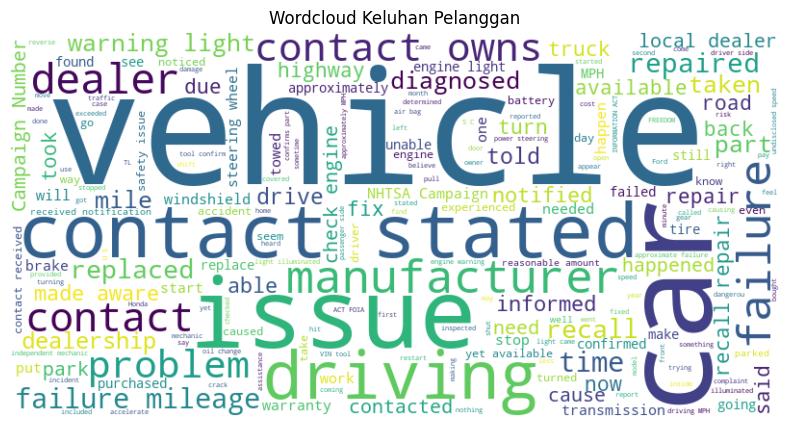

In [16]:
# 4.2.1 Wordcloud dari kolom summary

text = " ".join(df['summary'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Keluhan Pelanggan')
plt.show()

Wordcloud di atas menampilkan kata-kata yang paling sering muncul dalam keluhan pelanggan mobil dari berbagai manufaktur berdasarkan data terbaru. Kata-kata seperti **"vehicle"**, **"contact"**, **"stated"**, **"manufacturer"**, **"car"**, dan **"dealer"** mendominasi wordcloud, menunjukkan bahwa keluhan pelanggan banyak berfokus pada kendaraan secara umum, proses pelaporan, serta interaksi dengan produsen dan dealer. Selain itu, kata **"failure"**, **"issue"**, **"driving"**, dan **"replaced"** juga sering muncul, menandakan banyak keluhan terkait masalah teknis, pengalaman berkendara, serta tindakan perbaikan atau penggantian komponen.

Pola ini mengindikasikan bahwa isu utama yang dihadapi pelanggan mobil tidak hanya berkaitan dengan kerusakan kendaraan, tetapi juga proses penanganan keluhan dan komunikasi dengan pihak produsen atau dealer. Wordcloud ini memberikan gambaran awal mengenai fokus utama keluhan pelanggan sebelum dilakukan analisis lebih mendalam pada tahap selanjutnya.

### 4.2.2 Visualisasi distribusi label (bar chart).

components
ENGINE                     24589
OTHER                      19621
POWER TRAIN                18301
ELECTRICAL                 15287
VISIBILITY & LIGHTING      12801
RESTRAINTS & AIRBAGS       10154
STEERING                    9847
BRAKES                      9194
ADAS & STABILITY            8521
STRUCTURE/BODY              7471
WHEELS/TIRES/SUSPENSION     5865
FUEL & PROPULSION           5719
ENGINE COOLING              4038
Name: count, dtype: int64


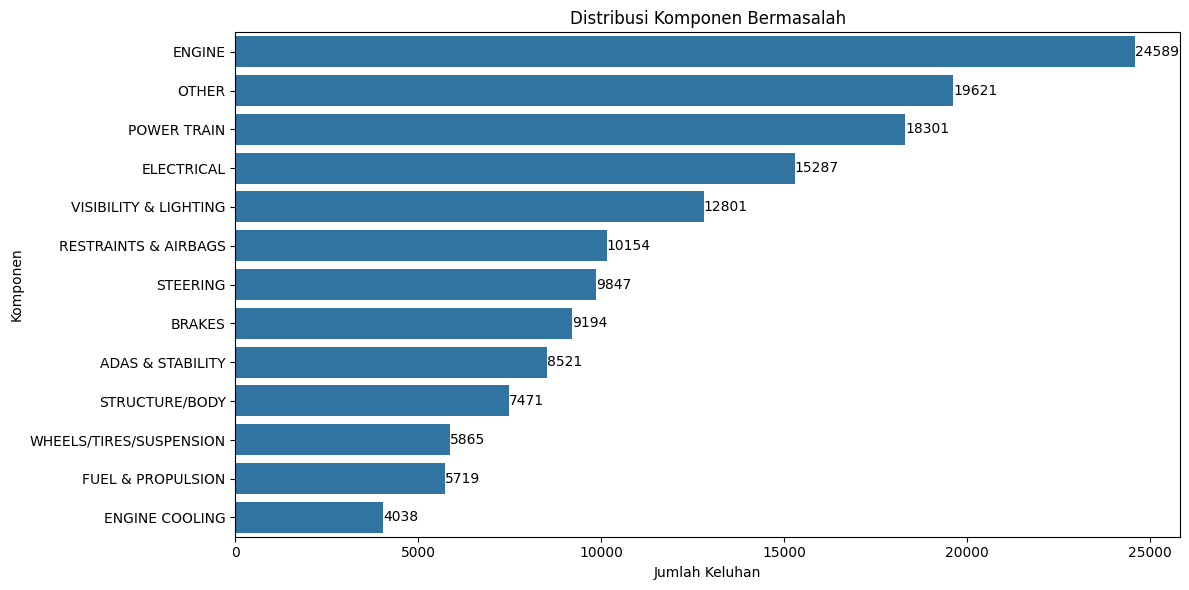

In [17]:
# 4.2.2 Visualisasi distribusi label (bar chart)

# Tampilkan jumlah keluhan per komponen
print(df['components'].value_counts())

# Visualisasi distribusi label (bar chart)
plt.figure(figsize=(12,6))
ax=sns.countplot(y='components', data=df, order=df['components'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.title('Distribusi Komponen Bermasalah')
plt.xlabel('Jumlah Keluhan')
plt.ylabel('Komponen')
plt.tight_layout()
plt.show()

Grafik di atas menunjukkan distribusi jumlah keluhan pelanggan mobil berdasarkan kategori komponen yang dikeluhkan. Komponen **ENGINE** menjadi yang paling sering dikeluhkan, diikuti oleh **OTHER**, **POWER TRAIN**, dan **ELECTRICAL**. Sementara itu, kategori seperti **ENGINE COOLING**, **FUEL & PROPULSION**, dan **WHEELS/TIRES/SUSPENSION** memiliki jumlah keluhan yang jauh lebih sedikit. Distribusi ini menandakan adanya ketimpangan (imbalance) antar kelas, sehingga model klasifikasi perlu strategi khusus agar tidak bias ke kelas mayoritas. Selain itu, insight ini juga dapat digunakan oleh produsen untuk memprioritaskan perbaikan pada komponen yang paling sering bermasalah.

### 4.2.3 Visualisasi distribusi tahun mobil (`modelYear`).

modelYear
2016    29848
2017    28335
2018    23986
2019    19764
2020    14614
2021    11131
2022     9879
2023     7230
2024     5174
2025     1416
2026       31
Name: count, dtype: Int64


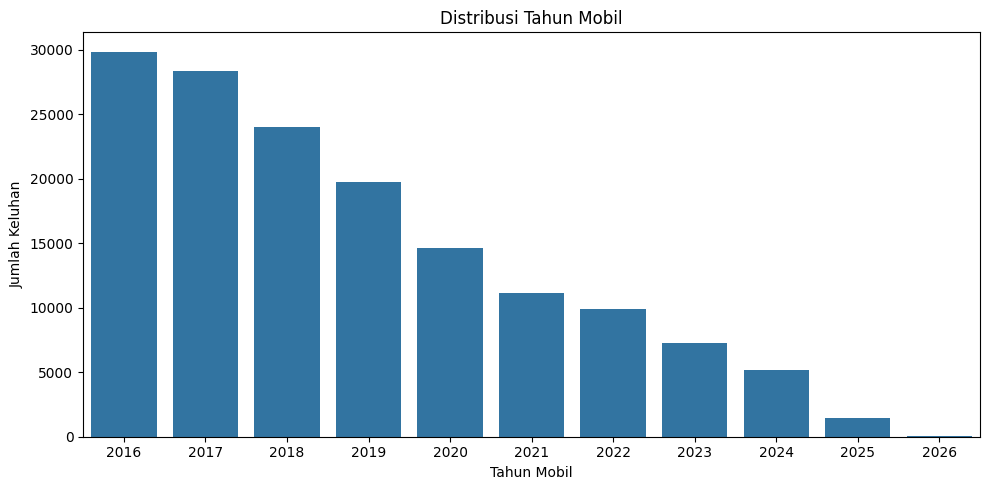

In [18]:
# 4.2.3 Visualisasi distribusi tahun mobil (modelYear)
# Tampilkan jumlah keluhan per tahun mobil
print(df['modelYear'].value_counts().sort_index())

plt.figure(figsize=(10,5))
sns.countplot(x='modelYear', data=df, order=sorted(df['modelYear'].dropna().unique()))
plt.title('Distribusi Tahun Mobil')
plt.xlabel('Tahun Mobil')
plt.ylabel('Jumlah Keluhan')
plt.tight_layout()
plt.show()

Grafik di atas menunjukkan distribusi jumlah keluhan berdasarkan tahun mobil. Terlihat bahwa mobil keluaran tahun 2016 hingga 2019 memiliki jumlah keluhan yang paling tinggi, sedangkan mobil yang lebih baru (2022 ke atas) jumlah keluhannya semakin sedikit. Pola ini wajar karena mobil yang lebih lama cenderung mengalami lebih banyak masalah akibat usia pakai, sementara mobil baru belum banyak digunakan atau belum cukup lama untuk menunjukkan masalah. Selain itu, data untuk tahun-tahun terbaru juga bisa jadi belum lengkap karena waktu pengumpulan keluhan yang lebih singkat.

### 4.2.4 Visualisasi insiden crash.

crash
False    145945
True       5463
Name: count, dtype: int64


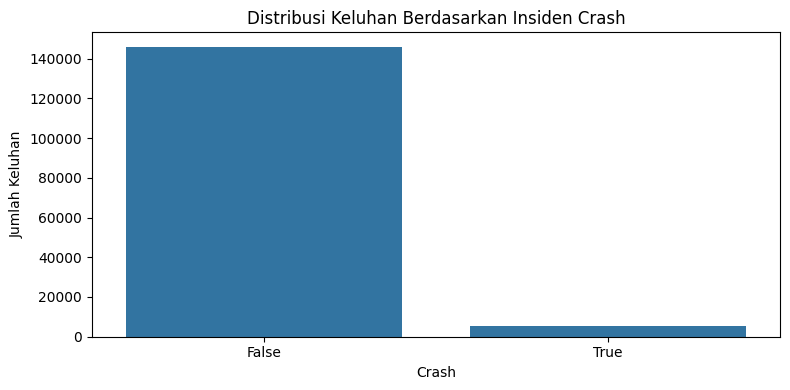

In [19]:
# 4.2.4 Visualisasi insiden crash
# Tampilkan jumlah keluhan berdasarkan insiden crash
print(df['crash'].value_counts())

plt.figure(figsize=(8,4))
sns.countplot(x='crash', data=df)
plt.title('Distribusi Keluhan Berdasarkan Insiden Crash')
plt.xlabel('Crash')
plt.ylabel('Jumlah Keluhan')
plt.tight_layout()
plt.show()

### 4.2.5 Visualisasi insiden fire.

fire
False    149844
True       1564
Name: count, dtype: int64


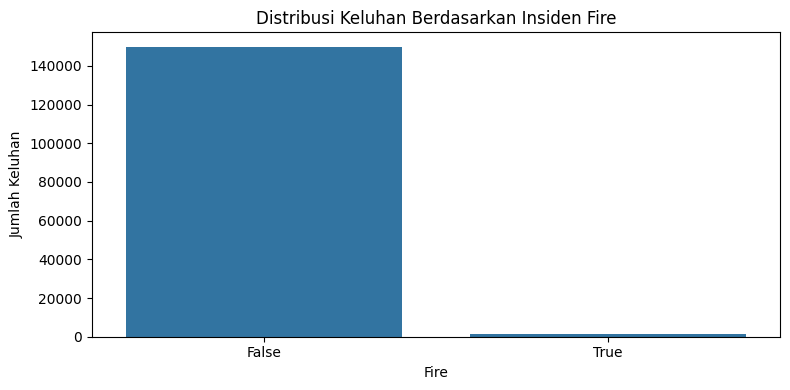

In [20]:
# 4.2.5 Visualisasi insiden fire
# Tampilkan jumlah keluhan berdasarkan insiden fire
print(df['fire'].value_counts())

plt.figure(figsize=(8,4))
sns.countplot(x='fire', data=df)
plt.title('Distribusi Keluhan Berdasarkan Insiden Fire')
plt.xlabel('Fire')
plt.ylabel('Jumlah Keluhan')
plt.tight_layout()
plt.show()

Grafik di atas menunjukkan distribusi keluhan berdasarkan insiden **fire** (kebakaran) dan **crash** (kecelakaan). Terlihat bahwa sebagian besar keluhan **tidak** terkait dengan insiden kebakaran maupun kecelakaan. Hanya sebagian kecil keluhan yang melaporkan adanya insiden fire atau crash. Hal ini menunjukkan bahwa kasus kebakaran dan kecelakaan merupakan kejadian yang relatif jarang dibandingkan total keluhan yang masuk. Mayoritas keluhan pelanggan lebih banyak berkaitan dengan masalah teknis atau fungsional kendaraan, bukan insiden berat seperti kebakaran atau kecelakaan.

# 5. Text Preprocessing.

---

Pada tahap ini dilakukan serangkaian proses pembersihan dan normalisasi data teks pada kolom `summary` agar siap digunakan untuk analisis NLP dan modeling. Berikut tahapan yang dijalankan:

### 5.1 Daftar Kata Penting Otomotif (Domain Keep-list)
- Mendefinisikan kumpulan kata teknis otomotif (`AUTO_KEEP`) yang **wajib dipertahankan** selama proses cleaning, agar istilah penting tidak terhapus meskipun mirip stopwords.
- Termasuk penambahan bentuk jamak dan varian tanpa spasi/hyphen.

In [21]:
# Daftar kata teknis otomotif yang wajib dipertahankan selama proses cleaning.
AUTO_KEEP = {
    # Engine & Fuel
    "engine", "motor", "coolant", "radiator", "thermostat", "overheat", "overheating", "misfire", "stall", "stalled", "idling", "idle",
    "oil", "filter", "spark", "sparkplug", "plug", "injector", "fuel", "pump", "nozzle", "tank", "maf", "map", "o2", "lambda", "tps", "egr", "evap",
    # Electrical
    "battery", "alternator", "starter", "voltage", "wiring", "harness", "short", "ground", "relay", "fuse", "ecu", "pcm", "can", "bus", "sensor", "actuator", "module",
    # Power Train
    "transmission", "gearbox", "gear", "cvt", "dct", "clutch", "torque", "converter", "drivetrain", "powertrain", "differential", "axle", "driveshaft", "shifter", "shift", "engage", "slip", "jerk",
    # Brakes
    "brake", "brakes", "braking", "abs", "pad", "pads", "rotor", "caliper", "booster", "hydraulic", "fluid", "epb", "spongy", "soft", "fade",
    # Steering
    "steer", "steering", "rack", "pinion", "alignment", "wander", "pull",
    # Wheels/Tires/Suspension
    "wheel", "wheels", "rim", "hub", "lug", "bearing", "tire", "tyre", "tires", "tyres", "pressure", "psi", "tpms",
    "suspension", "strut", "shock", "bushing", "linkage", "controlarm", "stabilizer", "swaybar",
    # Restraints & Airbags
    "airbag", "airbags", "srs", "pretensioner", "seatbelt", "seatbelts", "restraint", "deploy", "deployment",
    # Visibility & Lighting
    "headlight", "headlamp", "taillight", "foglight", "lamp", "bulb", "beam", "wiper", "windshield", "windscreen", "washer", "mirror", "flicker", "flickering", "dim",
    # ADAS & Stability
    "esc", "esp", "stability", "traction", "lane", "ldw", "fcw", "adas", "radar", "lidar", "camera", "cruise", "adaptive",
    # HVAC & Exhaust
    "hvac", "heater", "ac", "a/c", "compressor", "evaporator", "expansion", "condenser", "blower", "cabin", "filter",
    "exhaust", "muffler", "catalyst", "catalytic", "converter", "o2sensor", "dpf", "scr",
    # Misc Ops
    "speed", "mph", "kmh", "kph", "rpm", "throttle", "pedal", "warning", "malfunction", "limp", "limpmode",
    # Energy/EV
    "hybrid", "hev", "phev", "ev", "inverter", "charger", "charging", "soc", "soh", "bms", "dc", "dc/dc", "highvoltage", "hv", "12v", "48v", "400v", "800v",
    # Body/Structure
    "door", "hood", "trunk", "tailgate", "bumper", "fender", "pillar", "chassis", "frame", "corrosion", "rust", "paint",
}
# Tambahkan bentuk jamak dan varian tanpa spasi/hyphen
AUTO_KEEP |= {w + "s" for w in list(AUTO_KEEP) if not w.endswith("s")}
AUTO_KEEP |= {w.replace(" ", "") for w in list(AUTO_KEEP)}
AUTO_KEEP |= {w.replace("-", "") for w in list(AUTO_KEEP)}

### 5.2 Stopwords Dasar (Base Stopwords)
- Menyusun daftar stopwords bahasa Inggris umum (`BASE_STOP`) **tanpa kata negasi**.
- Kata administratif seperti "vehicle", "dealer", dll juga dihapus, kecuali yang termasuk kata penting otomotif.

In [22]:
# Stopwords dasar bahasa Inggris, tanpa kata negasi.
BASE_STOP = {
    "a", "an", "the", "and", "or", "but", "if", "then", "than", "so", "because", "while", "of", "to", "for", "from", "by",
    "on", "in", "at", "as", "with", "about", "into", "through", "over", "under", "between", "within",
    "is", "am", "are", "was", "were", "be", "been", "being", "do", "does", "did", "done", "have", "has", "had",
    "can", "could", "shall", "should", "will", "would", "may", "might", "must",
    "i", "im", "i'm", "ive", "id", "we", "our", "you", "your", "he", "she", "it", "they", "them", "their",
    "this", "that", "these", "those", "there", "here", "where", "when", "why", "how",
    "very", "really", "just", "also", "still", "yet", "only", "even", "ever", "never", "always", "often", "sometimes", "usually",
    "more", "most", "less", "least", "lot", "lots", "many", "much", "few", "several", "some", "any", "none",
    "up", "down", "again", "back", "away", "out", "off", "around", "across", "along", "together",
    # kata administratif
    "contact", "contacts", "consumer", "owner", "dealer", "manufacturer", "manuf", "vehicle", "vehicles"
}
BASE_STOP = {w for w in BASE_STOP if w not in AUTO_KEEP}

### 5.3 Regex & Tokenisasi
- Menyiapkan berbagai pola regex untuk mendeteksi token teknis (kode DTC, VIN, email, URL, dsb).
- Fungsi `_is_whitelisted` untuk memastikan token penting tetap dipertahankan.
- Fungsi `_normalize_special` untuk mengganti token tertentu (tahun, volt, dsb) dengan placeholder.

In [23]:
# 5.3 Regex & Tokenisasi
RE_TOKEN = re.compile(r"[A-Za-z0-9]+(?:[-/\.][A-Za-z0-9]+)*")
RE_REPEAT3 = re.compile(r"(.)\1{2,}")
VOWELS = set("aeiouAEIOU")

# Regex untuk deteksi kode teknis, VIN, email, URL, dsb.
RE_DTC      = re.compile(r"^[PBUC]\d{4}$", re.I)
RE_ACRONYM  = re.compile(r"^[A-Z]{2,6}$")
RE_ALNUM    = re.compile(r"^[A-Za-z0-9]+(?:[-/\.][A-Za-z0-9]+)*$")
RE_YEAR     = re.compile(r"^(19[5-9]\d|20[0-3]\d)$")
RE_VOLT     = re.compile(r"^\d{2,4}v$", re.I)
RE_UNITPSI  = re.compile(r"^\d{1,3}psi$", re.I)
RE_SPEED1   = re.compile(r"^\d{1,3}mph$", re.I)
RE_SPEED2   = re.compile(r"^\d{1,3}(kph|kmh)$", re.I)
RE_TEMP     = re.compile(r"^\d{1,3}[CF]$", re.I)
RE_VIN      = re.compile(r"\b[0-9A-HJ-NPR-Z]{11,17}\b")
RE_PHONE    = re.compile(r"\b(?:\+?\d{1,3}[-.\s]?)?(?:\(?\d{3}\)?[-.\s]?){2}\d{4}\b")
RE_EMAIL    = re.compile(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b")
RE_URL      = re.compile(r"https?://\S+")

def _is_whitelisted(tok: str) -> bool:
    if len(tok) >= 50:
        return False
    if (RE_DTC.match(tok) or RE_ACRONYM.match(tok) or RE_YEAR.match(tok) or RE_VOLT.match(tok) or
        RE_UNITPSI.match(tok) or RE_SPEED1.match(tok) or RE_SPEED2.match(tok) or RE_TEMP.match(tok) or
        RE_ALNUM.match(tok)):
        return True
    if tok.lower() in AUTO_KEEP:
        return True
    return False

def _normalize_special(tok: str) -> str:
    if RE_YEAR.match(tok): return "<YEAR>"
    if RE_VOLT.match(tok): return "<VOLT>"
    if RE_UNITPSI.match(tok): return "<PSI>"
    if RE_SPEED1.match(tok) or RE_SPEED2.match(tok): return "<SPEED>"
    if RE_TEMP.match(tok): return "<TEMP>"
    return tok

### 5.4 Scrubbing Boilerplate & PII
- Menghapus frasa boilerplate (template laporan) dan data sensitif (PII) seperti URL, email, nomor telepon, dan VIN dari teks keluhan.
- Menggunakan regex untuk membersihkan karakter non-alfanumerik yang tidak relevan.

In [24]:
# 5.4 Scrubbing Boilerplate & PII
PHRASE_PATTERNS = [
    r"\bTL\*?\b",
    r"\bTHE\s+CONTACT(?:\s+OWNER)?\b",
    r"\bTHE\s+CONSUMER\b",
    r"\bTHE\s+OWNER\b",
    r"\bTHE\s+DEALER\b",
    r"\bTHE\s+MANUFACTURER\b",
    r"\bCONTACT(?:ED)?\s+THE\s+DEALER\b",
    r"\bCONTACT(?:ED)?\s+THE\s+MANUFACTURER\b",
    r"\bSTATED\s+THAT\b",
    r"\bWAS\s+ADVISED\b",
    r"\bWAS\s+INFORMED\b",
    r"\bWAS\s+TOLD\b",
    r"\bWAS\s+UNABLE\b",
    r"\bWERE\s+UNABLE\b",
    r"\bTHE\s+FAILURE\s+RECURRED\b",
    r"\bTHE\s+FAILURE\b",
]
PHRASE_REGEX = [re.compile(pat, flags=re.I) for pat in PHRASE_PATTERNS]

def scrub_boilerplate(s: str) -> str:
    s = RE_URL.sub(" <URL> ", s)
    s = RE_EMAIL.sub(" <EMAIL> ", s)
    s = RE_PHONE.sub(" <PHONE> ", s)
    s = RE_VIN.sub(" <VIN> ", s)
    for rgx in PHRASE_REGEX:
        s = rgx.sub(" ", s)
    s = re.sub(r"[^A-Za-z0-9\-\./\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

### 5.5 Mining Noise Otomatis
- Mengidentifikasi kata-kata **noise** secara otomatis dari data (misal: typo, token aneh, dsb) menggunakan statistik karakter dan frekuensi token.
- Fungsi `mine_noise_lexicon` menghasilkan daftar kata noise dari data.

In [25]:
# 5.5 Mining Noise Otomatis
def _char_stats(tok: str):
    L = len(tok); uniq = len(set(tok))
    digits = sum(c.isdigit() for c in tok)
    letters = sum(c.isalpha() for c in tok)
    vowels  = sum(c in VOWELS for c in tok)
    max_run, cur = 1, 1
    for i in range(1, L):
        if tok[i] == tok[i-1]:
            cur += 1; max_run = max(max_run, cur)
        else:
            cur = 1
    return {
        "L": L, "uniq": uniq, "digits": digits, "letters": letters, "vowels": vowels,
        "max_run": max_run, "uniq_ratio": (uniq / L) if L else 0.0,
        "vowel_ratio": (vowels / max(letters, 1)) if letters else 0.0
    }

def _is_noise_candidate(tok: str, freq: int) -> bool:
    if len(tok) >= 50: return True
    if _is_whitelisted(tok): return False
    st = _char_stats(tok); L = st["L"]
    if L > 30: return True
    if L <= 1: return True
    if st["max_run"] >= 3: return True
    if st["uniq_ratio"] <= 0.34 and L >= 4: return True
    if st["letters"] >= 4 and st["vowel_ratio"] == 0.0: return True
    if freq <= 2 and (st["uniq_ratio"] < 0.5 or st["letters"] == 0): return True
    return False

def mine_noise_lexicon(series_of_text: pd.Series, min_count:int=1):
    counts = Counter()
    for s in series_of_text.astype(str):
        s = scrub_boilerplate(s)
        toks = RE_TOKEN.findall(s)
        toks = [RE_REPEAT3.sub(r"\1\1", t) for t in toks]
        counts.update(toks)
    noise = set()
    for tok, c in counts.items():
        if _is_noise_candidate(tok, c):
            noise.add(tok.lower())
    noise = {w for w in noise if not _is_whitelisted(w) and w not in AUTO_KEEP}
    return noise, counts

### 5.6 Manual Noise List (Opsional)
- Jika tersedia file eksternal (`List kata tidak relevan.txt`), daftar kata tidak relevan juga dimasukkan ke noise list.

In [26]:
# 5.6 Manual Noise List
manual_noise = set()
p = Path("List kata tidak relevan.txt")
if p.exists():
    try:
        raw = p.read_text(errors="ignore")
        cand = re.findall(r"[A-Za-z0-9][A-Za-z0-9\-/\.]*", raw)
        manual_noise = {c.lower() for c in cand if c}
        manual_noise = {w for w in manual_noise if not _is_whitelisted(w) and w not in AUTO_KEEP}
    except Exception:
        manual_noise = set()

### 5.7 Final Stopwords (Gabungan)
- Menggabungkan semua stopwords: base stopwords, hasil mining noise otomatis, dan manual noise list, **kecuali kata penting otomotif**.
- Hasil akhir adalah `FINAL_STOP`, yaitu daftar kata yang akan dihapus dari teks.

In [27]:
# 5.7 Final Stopwords (Gabungan)
noise_auto, token_counts = mine_noise_lexicon(df["summary"], min_count=1)
FINAL_STOP = set(w for w in BASE_STOP if w not in AUTO_KEEP)
FINAL_STOP |= (noise_auto | manual_noise)
FINAL_STOP = {w for w in FINAL_STOP if (w not in AUTO_KEEP)}

print(f"Auto-mined noise: {len(noise_auto)} | Manual noise: {len(manual_noise)} | FINAL_STOP: {len(FINAL_STOP)}")

Auto-mined noise: 278 | Manual noise: 0 | FINAL_STOP: 402


### 5.8 Fungsi Cleaning Utama
- Fungsi `clean_text_domain_aware` melakukan proses cleaning secara menyeluruh:
  - Case folding, penghapusan boilerplate/PII, tokenisasi, filtering stopwords, noise, dan kata terlalu panjang.
  - Kata negasi tetap dipertahankan.
  - Kata teknis otomotif dan token whitelist tetap dipertahankan.
- Hasil cleaning disimpan di kolom baru `summary_clean`.
- Baris dengan hasil cleaning terlalu pendek (<10 karakter) dihapus.

In [28]:
# 5.8 Fungsi Cleaning Utama
NEGATIONS = {"no", "not", "without", "never", "doesnt", "doesn't", "cant", "can't", "wont", "won't"}

def clean_text_domain_aware(s: str) -> str:
    s = scrub_boilerplate(str(s))
    toks = RE_TOKEN.findall(s)
    out = []
    for tok in toks:
        tok = RE_REPEAT3.sub(r"\1\1", tok)
        low = tok.lower()
        if len(tok) >= 50:
            continue
        if any(x in low for x in ['www', 'http', 'https', '.com', '.net', '.org', '.gov', '.edu']):
            continue
        if low in NEGATIONS:
            out.append(low)
            continue
        if _is_whitelisted(tok) or (low in AUTO_KEEP):
            out.append(_normalize_special(tok))
            continue
        if low in FINAL_STOP:
            continue
        if _is_noise_candidate(tok, token_counts.get(tok, 1)):
            continue
        out.append(low)
    cleaned = " ".join(t for t in out if t)
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    return cleaned

df["summary_clean"] = df["summary"].astype(str).apply(clean_text_domain_aware)
df = df[df["summary_clean"].str.len() >= 10].copy()
print("After clean:", df.shape)

After clean: (151263, 17)


### 5.9 Statistik Cleaning & Pratinjau
- Menghitung statistik jumlah token dan vocabulary sebelum dan sesudah cleaning.
- Menampilkan perbandingan jumlah token/vocab sebelum dan sesudah cleaning.
- Menampilkan preview hasil cleaning pada beberapa baris data.

In [29]:
# 5.9 Statistik Cleaning & Pratinjau
def _quick_token_stats(texts: pd.Series):
    n_tok = sum(len(t.split()) for t in texts)
    vocab = set()
    for t in texts: vocab.update(t.split())
    return n_tok, len(vocab)

_raw_tok, _raw_voc = _quick_token_stats(df["summary"].astype(str))
_cln_tok, _cln_voc = _quick_token_stats(df["summary_clean"])

print(f"Tokens raw: {_raw_tok:,} | Vocab raw: {_raw_voc:,}")
print(f"Tokens cln: {_cln_tok:,} | Vocab cln: {_cln_voc:,}")
print(f"↓ token ratio: {_cln_tok/_raw_tok:.2f} | ↓ vocab ratio: {_cln_voc/_raw_voc:.2f}")

preview = (
    df[["summary", "summary_clean"]]
    .assign(len_raw=df["summary"].str.split().str.len(),
            len_cln=df["summary_clean"].str.split().str.len())
    .head(8)
)
display(preview)

Tokens raw: 14,413,151 | Vocab raw: 257,819
Tokens cln: 13,905,347 | Vocab cln: 128,191
↓ token ratio: 0.96 | ↓ vocab ratio: 0.50


summary  \
1  TRAVELING AT HIGHWAY SPEED, THE WINDSHIELD SEE...   
2  TL* THE CONTACT OWNS A 2016 ALUMA AE716TA TRAI...   
3  WHILE TRAVELING AT HIGHWAY SPEEDS, THE SORENTO...   
4  SINCE THE PURCHASE OF THIS VEHICLE IT HAS AN U...   
5  TL* THE CONTACT OWNS A 2016 KIA SORENTO. WHILE...   
6  GLASS CRACKED FROM TOP, MIDDLE PORTION OF WIND...   
7  WHILE DRIVING ON THE HIGHWAY, WE NOTICED A CRA...   
8  TL* THE CONTACT OWNS A 2016 GRAND DESIGN REFLE...   

                                       summary_clean  len_raw  len_cln  
1  TRAVELING AT HIGHWAY SPEED THE WINDSHIELD SEEM...       61       61  
2  OWNS A <YEAR> ALUMA AE716TA TRAILER NA WHILE P...       47       40  
3  WHILE TRAVELING AT HIGHWAY SPEEDS THE SORENTO ...      106      104  
4  SINCE THE PURCHASE OF THIS VEHICLE IT HAS AN U...      118      118  
5  OWNS A <YEAR> KIA SORENTO WHILE DRIVING APPROX...       67       55  
6  GLASS CRACKED FROM TOP MIDDLE PORTION OF WINDS...       61       62  
7  WHILE DRIVING ON THE HIGHWAY WE NOTICED A CRAC...      347      341  
8  OWNS A <YEAR> GRAND DESIGN REFLECTION 337 WHIL...       60       53

**Kesimpulan:**  
Tahapan ini memastikan data teks keluhan sudah bersih dari kata tidak relevan, noise, dan boilerplate, namun tetap mempertahankan istilah teknis otomotif yang penting untuk analisis dan modeling. Data hasil cleaning siap digunakan untuk tahap feature extraction, vectorization, dan training model NLP.

---

### 5.10 Temukan baris dengan jumlah kata terbanyak di `summary_clean`

In [30]:
# Temukan baris dengan jumlah kata terbanyak di summary_clean
df['summary_clean_word_count'] = df['summary_clean'].apply(lambda x: len(str(x).split()))
max_word_count = df['summary_clean_word_count'].max()
df_max_words = df[df['summary_clean_word_count'] == max_word_count]

print(f"Jumlah kata terbanyak di summary_clean: {max_word_count}")
display(df_max_words[['summary', 'summary_clean', 'summary_clean_word_count']])

Jumlah kata terbanyak di summary_clean: 725


summary  \
153219  Dear Sir/Madam:  I want to make you aware of t...   

                                            summary_clean  \
153219  Dear Sir/Madam I want to make you aware of the...   

        summary_clean_word_count  
153219                       725

### 5.11 Menampilkan component dari data dengan `summary_clean_word_count` > 200

In [31]:
# Menampilkan component dari data dengan summary_clean_word_count > 200
df_lebih_200 = df[df['summary_clean_word_count'] > 200]
print("Jumlah data dengan lebih dari 200 kata:", len(df_lebih_200))
print("Distribusi komponen pada data tersebut:")
print(df_lebih_200['components'].value_counts())
print("Daftar komponen unik:", df_lebih_200['components'].unique())

Jumlah data dengan lebih dari 200 kata: 12510
Distribusi komponen pada data tersebut:
components
ENGINE                     2789
OTHER                      1823
POWER TRAIN                1622
ELECTRICAL                 1147
BRAKES                      816
ADAS & STABILITY            764
STEERING                    718
VISIBILITY & LIGHTING       680
FUEL & PROPULSION           640
WHEELS/TIRES/SUSPENSION     589
RESTRAINTS & AIRBAGS        481
STRUCTURE/BODY              400
ENGINE COOLING               41
Name: count, dtype: int64
Daftar komponen unik: ['VISIBILITY & LIGHTING' 'WHEELS/TIRES/SUSPENSION' 'OTHER' 'ENGINE'
 'POWER TRAIN' 'RESTRAINTS & AIRBAGS' 'FUEL & PROPULSION'
 'ADAS & STABILITY' 'BRAKES' 'ELECTRICAL' 'STRUCTURE/BODY' 'STEERING'
 'ENGINE COOLING']


In [32]:
# Hapus data dengan summary_clean_word_count > 200
df = df[df['summary_clean_word_count'] <= 200].copy()
print("Jumlah data setelah menghapus yang lebih dari 200 kata:", len(df))

# Hapus data dengan summary_clean_word_count < 2 (hanya 1 kata)
df = df[df['summary_clean_word_count'] >= 2].copy()
print("Jumlah data setelah menghapus yang hanya 1 kata:", len(df))

Jumlah data setelah menghapus yang lebih dari 200 kata: 138753
Jumlah data setelah menghapus yang hanya 1 kata: 138745


Menghapus data dengan `summary_clean_word_count > 200` sangat penting untuk menjaga kualitas dan konsistensi data sebelum modeling. Data keluhan yang terlalu panjang biasanya merupakan outlier, bisa berisi informasi berulang, atau bahkan noise yang tidak relevan dengan mayoritas data. Dengan membatasi jumlah kata maksimal, proses pelatihan model menjadi lebih efisien, mengurangi risiko overfitting pada kasus khusus, serta memastikan input ke model lebih seragam dan representatif terhadap pola keluhan pelanggan pada umumnya. Langkah ini juga sesuai dengan best practice NLP agar model lebih cepat, stabil, dan hasil prediksi lebih akurat.

### 5.11 Buat wordcloud untuk setiap label utama di components

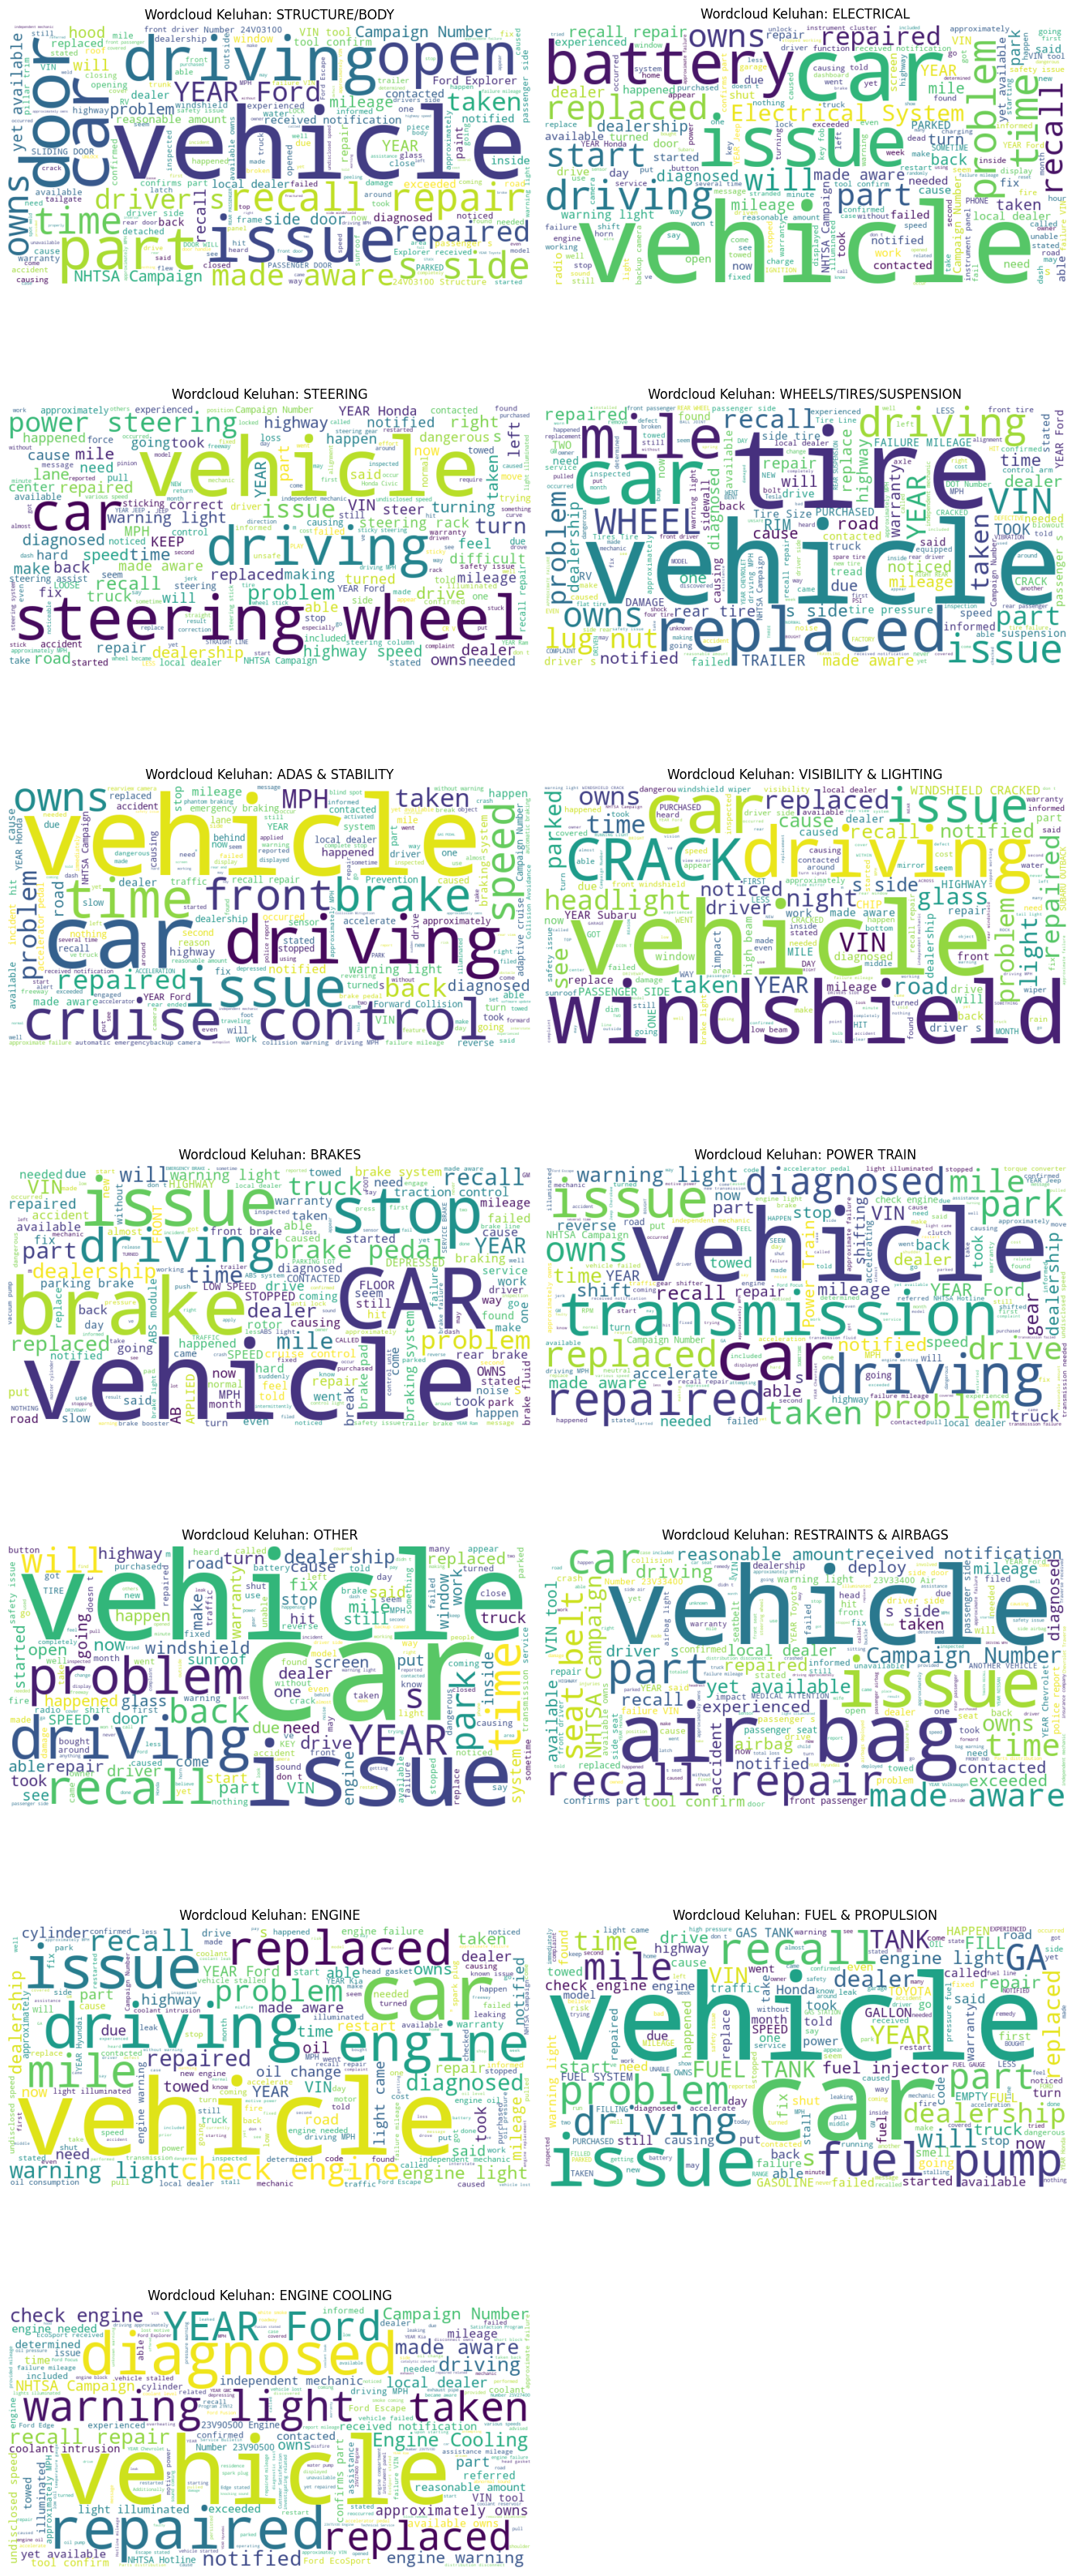

In [33]:
# Buat wordcloud untuk setiap label utama di components, tampilkan 2 kolom per baris
labels = df['components'].unique()
n_labels = len(labels)
n_cols = 2
n_rows = (n_labels + n_cols - 1) // n_cols

plt.figure(figsize=(14, 5 * n_rows))
for idx, label in enumerate(labels):
    text_label = " ".join(df[df['components'] == label]['summary_clean'].astype(str))
    if not text_label.strip():
        continue  # Lewati jika tidak ada teks
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_label)
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud Keluhan: {label}')
plt.tight_layout()
plt.show()

# 6. Target Conversion.

Mapping label FINAL: {'ADAS & STABILITY': 0, 'BRAKES': 1, 'ELECTRICAL': 2, 'ENGINE': 3, 'ENGINE COOLING': 4, 'FUEL & PROPULSION': 5, 'OTHER': 6, 'POWER TRAIN': 7, 'RESTRAINTS & AIRBAGS': 8, 'STEERING': 9, 'STRUCTURE/BODY': 10, 'VISIBILITY & LIGHTING': 11, 'WHEELS/TIRES/SUSPENSION': 12}
Label mapping FINAL disimpan ke label_mapping.json


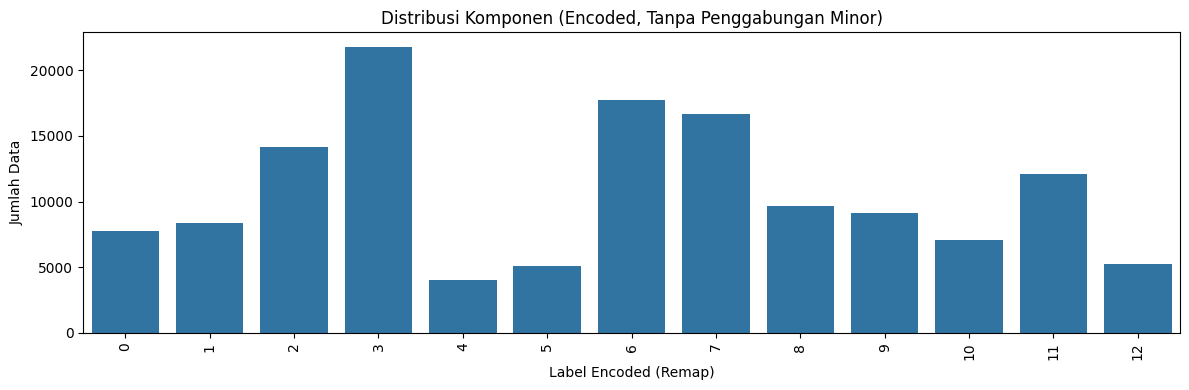

In [34]:
# --- 6. Target Conversion (Label Normalization & Remapping) ---

# 1. Encode semua label pada kolom 'components'
le = LabelEncoder()
df['components_encoded'] = le.fit_transform(df['components'])

# 2. Hapus label yang jumlahnya kurang dari 2 (filtering minor class, opsional)
label_counts = df['components_encoded'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df_filtered = df[df['components_encoded'].isin(valid_labels)].copy()

# 3. Remap label encoded di df_filtered ke urutan baru (0,1,...,num_classes-1)
class_to_index = {cls: idx for idx, cls in enumerate(sorted(valid_labels))}
df_filtered['components_encoded_remap'] = df_filtered['components_encoded'].map(class_to_index)
df_filtered = df_filtered.dropna(subset=['components_encoded_remap'])
df_filtered['components_encoded_remap'] = df_filtered['components_encoded_remap'].astype(int)

# 4. Mapping label FINAL ke index (hanya label yang dipakai model)
final_labels = sorted(df_filtered['components_encoded'].unique())
label_mapping_final = {le.inverse_transform([idx])[0]: int(i) for i, idx in enumerate(final_labels)}
print("Mapping label FINAL:", label_mapping_final)

# 5. Simpan mapping label ke file JSON (untuk inference/deployment)
with open('label_mapping.json', 'w') as f:
    json.dump(label_mapping_final, f, indent=2)
print("Label mapping FINAL disimpan ke label_mapping.json")

# 6. Visualisasi distribusi kelas (encoded)
num_classes = len(final_labels)
plt.figure(figsize=(12,4))
sns.countplot(x='components_encoded_remap', data=df_filtered, order=range(num_classes))
plt.title('Distribusi Komponen (Encoded, Tanpa Penggabungan Minor)')
plt.xlabel('Label Encoded (Remap)')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Berdasarkan hasil konversi target dan visualisasi distribusi kelas, terdapat **13 kategori komponen utama** pada data keluhan pelanggan mobil setelah proses filtering dan remapping label. Grafik distribusi memperlihatkan bahwa keluhan pelanggan sangat didominasi oleh beberapa komponen mayoritas, terutama **ENGINE, STRUCTURE, dan POWER TRAIN**. Ketiga kategori ini memiliki jumlah data yang jauh lebih besar dibandingkan kategori lain, sehingga terjadi **ketimpangan (imbalance) antar kelas** yang cukup signifikan.

Kondisi imbalance ini dapat menyebabkan model cenderung lebih akurat dalam mengenali kelas mayoritas, namun kurang optimal pada kelas minoritas. Oleh karena itu, pada tahap modeling perlu diterapkan strategi seperti **data augmentation pada kelas minoritas** dan penggunaan **class weight** agar model tidak bias hanya pada kelas mayoritas.

Mapping label ke bentuk numerik dan one-hot sangat membantu dalam interpretasi hasil prediksi model. Setiap label komponen sudah terstruktur dengan baik, sehingga data siap digunakan untuk training model berbasis ANN, LSTM, atau GRU.

Secara keseluruhan, proses konversi target sudah sesuai kebutuhan multi-class classification pada data keluhan pelanggan dari berbagai manufaktur mobil. Namun, risiko bias terhadap kelas mayoritas tetap perlu diantisipasi. Evaluasi model harus dilakukan secara menyeluruh di semua kelas agar performa model benar-benar adil dan representatif untuk seluruh kategori komponen yang ada.

---

# 7. EDA After Text Preprocessing.

## 7.1 Statistik Deskriptif Panjang Teks Setelah Preprocessing.

In [35]:
# 7.1 Statistik Deskriptif Panjang Teks Setelah Preprocessing

df['summary_clean_length'] = df['summary_clean'].apply(lambda x: len(str(x).split()))
print("Statistik panjang teks keluhan setelah preprocessing:")
print(df['summary_clean_length'].describe())

Statistik panjang teks keluhan setelah preprocessing:
count    138745.000000
mean         75.602530
std          45.009233
min           2.000000
25%          42.000000
50%          69.000000
75%         103.000000
max         200.000000
Name: summary_clean_length, dtype: float64


**Statistik Panjang Teks Keluhan Sebelum Preprocessing:**
- Rata-rata: **95 kata**
- Median: **80 kata**
- Minimum: **1 kata**
- Maksimum: **720 kata**
- Kuartil 25%: **45 kata**
- Kuartil 75%: **123 kata**
- Standar deviasi: **71 kata**

**Statistik Panjang Teks Keluhan Setelah Preprocessing:**
- Rata-rata: **75.6 kata**
- Median: **69 kata**
- Minimum: **2 kata**
- Maksimum: **200 kata**
- Kuartil 25%: **42 kata**
- Kuartil 75%: **103 kata**
- Standar deviasi: **45 kata**

**Analisis:**
- Setelah preprocessing, rata-rata dan median jumlah kata per keluhan **berkurang signifikan**, namun tetap cukup panjang sehingga informasi utama tetap terjaga.
- Minimum jumlah kata naik menjadi 2 kata (tidak ada lagi keluhan 1 kata), dan maksimum dibatasi 200 kata untuk menjaga konsistensi data.
- Rentang panjang teks menjadi lebih terkontrol, sehingga data lebih seragam dan efisien untuk modeling.
- Standar deviasi menurun, menandakan distribusi panjang teks antar keluhan menjadi lebih seragam.
- Proses ini membuat data lebih fokus pada kata-kata penting yang benar-benar merepresentasikan masalah teknis, sehingga dapat meningkatkan kualitas fitur untuk analisis NLP dan klasifikasi komponen bermasalah.

**Kesimpulan:**  
Preprocessing yang dilakukan sudah efektif, menghasilkan data yang lebih bersih, informatif, dan siap digunakan untuk tahap

## 7.2 Visualisasi Distribusi Panjang Teks

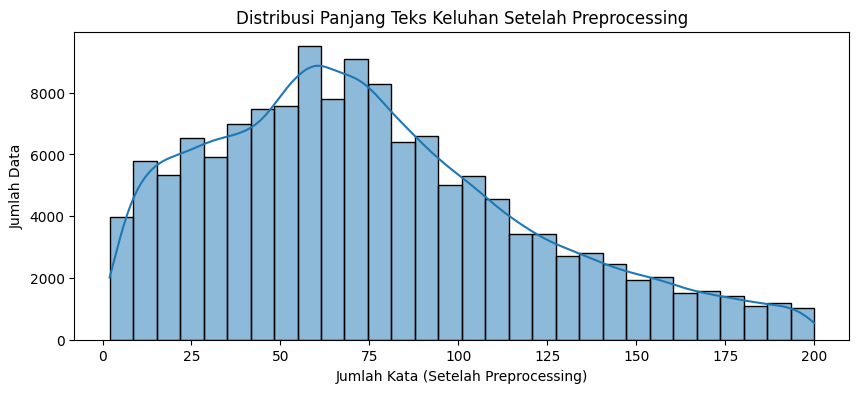

In [36]:
# 7.2 Visualisasi Distribusi Panjang Teks Setelah Preprocessing

plt.figure(figsize=(10,4))
sns.histplot(df['summary_clean_length'], bins=30, kde=True)
plt.title('Distribusi Panjang Teks Keluhan Setelah Preprocessing')
plt.xlabel('Jumlah Kata (Setelah Preprocessing)')
plt.ylabel('Jumlah Data')
plt.show()

Berdasarkan grafik di atas, distribusi panjang teks keluhan setelah preprocessing menunjukkan bahwa mayoritas keluhan pelanggan memiliki jumlah kata antara **40 hingga 100 kata**, dengan puncak distribusi di sekitar **60-80 kata**. Hanya sebagian kecil keluhan yang memiliki jumlah kata lebih dari 150, dan sangat sedikit yang mencapai batas maksimum 200 kata. Hal ini menunjukkan bahwa setelah proses pembersihan, sebagian besar keluhan menjadi lebih ringkas dan seragam, sehingga data lebih efisien untuk analisis dan modeling. Distribusi yang sedikit condong ke kanan (right-skewed) menandakan keluhan yang sangat panjang merupakan outlier. Dengan demikian, hasil preprocessing sudah optimal dan siap digunakan untuk tahap pemodelan NLP berikutnya.

## 7.3 Wordcloud dari Kolom summary_clean

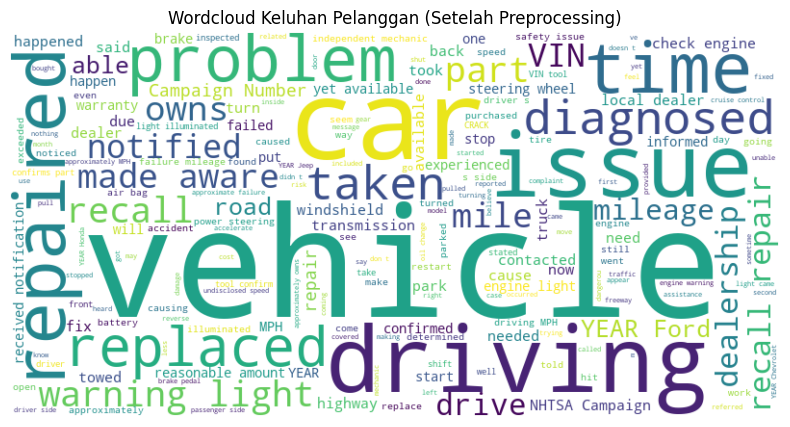

In [37]:
# 7.3 Wordcloud dari Kolom summary_clean

text_clean = " ".join(df['summary_clean'].astype(str))
wordcloud_clean = WordCloud(width=800, height=400, background_color='white').generate(text_clean)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_clean, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Keluhan Pelanggan (Setelah Preprocessing)')
plt.show()

Berdasarkan wordcloud di atas setelah dilakukan cleaning, terlihat bahwa kata-kata yang paling menonjol dalam keluhan pelanggan adalah **"vehicle"**, **"driving"**, **"issue"**, **"car"**, **"repaired"**, **"mile"**, **"problem"**, **"light"**, **"recall"**, dan **"warning"**. Kata-kata ini menunjukkan bahwa fokus utama keluhan pelanggan berkaitan dengan masalah teknis kendaraan, proses perbaikan, jarak tempuh, lampu peringatan, serta isu recall dan notifikasi.

Proses cleaning berhasil mengurangi kata-kata administratif dan tidak relevan, sehingga wordcloud lebih merepresentasikan isu teknis yang sebenarnya dihadapi pelanggan. Hasil ini sangat membantu dalam mengidentifikasi pola masalah yang sering terjadi dan dapat menjadi acuan bagi produsen untuk melakukan perbaikan pada komponen yang paling sering dikeluhkan.

## 7.4 Tampilkan Contoh Hasil Preprocessing

In [38]:
# 7.4 Tampilkan Contoh Hasil Preprocessing

print("Contoh hasil preprocessing:")
print(df[['summary', 'summary_clean']].sample(5))

Contoh hasil preprocessing:
                                                  summary  \
109320  The contact’s sister-in-law owns a 2017 Kia Op...   
111408  i’ve been experiencing not one or twice but mo...   
197129  I have been dealing with an engine issue for a...   
79750   The contact owns a 2020 Subaru Forester. The c...   
128027  The car repeatedly rapidly decelerates when pa...   

                                            summary_clean  
109320  s sister-in-law owns a <YEAR> Kia Optima while...  
111408  i ve been experiencing not one or twice but mo...  
197129  I have been dealing with an engine issue for a...  
79750   owns a <YEAR> Subaru Forester noticed that the...  
128027  The car repeatedly rapidly decelerates when pa...  


# 8. Data Splitting, Augmentation & Class Weight.

## 8.1 Data Splitting.

In [39]:
# --- 8. Data Splitting ---

# 1. Pisahkan fitur dan target dari df_filtered
X = df_filtered['summary_clean']
y = df_filtered['components_encoded_remap']

# 2. Split data: train, val, test (80% train+val, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp
)

# 3. Pastikan label di train hanya yang ada di validasi
valid_classes = np.unique(y_val)
mask = np.isin(y_train, valid_classes)
X_train = X_train[mask]
y_train = np.array(y_train)[mask]

print("Jumlah data train:", len(X_train))
print("Jumlah data val:", len(X_val))
print("Jumlah data test:", len(X_test))

Jumlah data train: 67984
Jumlah data val: 29137
Jumlah data test: 41624


In [40]:
# Get Vocabularies
Vectorize = CountVectorizer(min_df=5)
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)
X_train_vec

<67984x11839 sparse matrix of type '<class 'numpy.int64'>'
	with 3411130 stored elements in Compressed Sparse Row format>

In [41]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  11839
Maximum Sentence Length :  200 tokens


## 8.2 Data Augmentation.

Threshold minor class (20% mayor): 2134


Augmentasi random swap minor class: 100%|██████████| 67984/67984 [00:00<00:00, 2266171.51it/s]

Distribusi label train setelah augmentasi:
3     10618
6      8655
7      8133
2      6832
11     5903
8      4490
9      4451
1      4092
0      3779
10     3370
12     2553
5      2478
4      2023
Name: count, dtype: int64


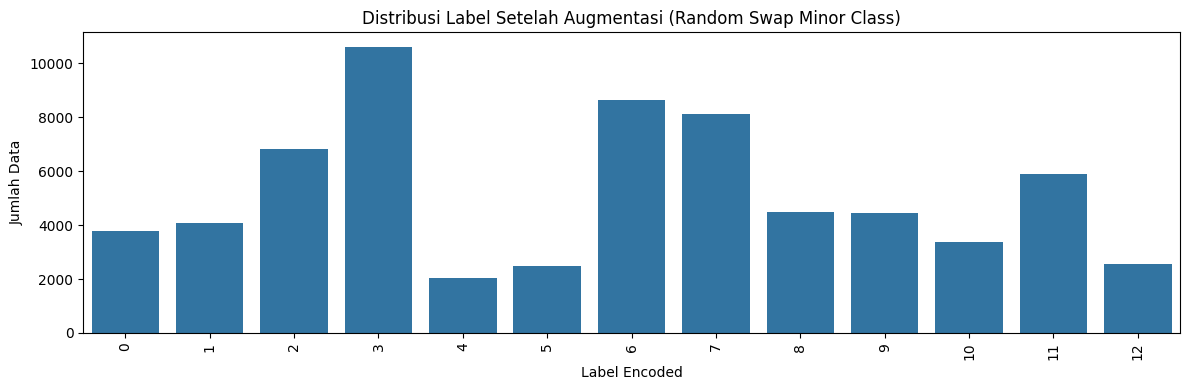

y_train_aug berhasil disimpan ke y_train_aug.npy


In [42]:
# Augmentasi hanya dengan random swap untuk minor class (PAKAI THRESHOLD PROPORSIONAL, BUKAN MEDIAN)
def random_swap_aug(text):
    tokens = text.split()
    if len(tokens) > 2:
        idx1, idx2 = random.sample(range(len(tokens)), 2)
        tokens[idx1], tokens[idx2] = tokens[idx2], tokens[idx1]
    return ' '.join(tokens)

X_train_aug = []
y_train_aug = []

train_label_counts = Counter(y_train)
max_count = max(train_label_counts.values())
minor_threshold = int(0.2 * max_count)  # Augmentasi hanya untuk kelas dengan <20% mayor class

print(f"Threshold minor class (20% mayor): {minor_threshold}")

# Hitung berapa banyak sample yang perlu ditambah agar minor class mendekati mayor class (tapi tidak melebihi)
augment_target = {label: max(0, minor_threshold - count) for label, count in train_label_counts.items() if count < minor_threshold}
aug_counts = Counter()

for text, label in tqdm(list(zip(X_train, y_train)), desc="Augmentasi random swap minor class"):
    X_train_aug.append(text)
    y_train_aug.append(label)
    # Augmentasi hanya untuk minor class, secukupnya
    if label in augment_target and aug_counts[label] < augment_target[label]:
        aug_text = random_swap_aug(text)
        if aug_text != text:
            X_train_aug.append(aug_text)
            y_train_aug.append(label)
            aug_counts[label] += 1

# Drop duplikat agar tidak overfit
aug_df = pd.DataFrame({'text': X_train_aug, 'label': y_train_aug})
aug_df = aug_df.drop_duplicates(subset=['text', 'label'])
X_train_aug = aug_df['text'].tolist()
y_train_aug = aug_df['label'].to_numpy()

print("Distribusi label train setelah augmentasi:")
print(pd.Series(y_train_aug).value_counts())

plt.figure(figsize=(12,4))
sns.countplot(x=y_train_aug)
plt.title('Distribusi Label Setelah Augmentasi (Random Swap Minor Class)')
plt.xlabel('Label Encoded') 
plt.ylabel('Jumlah Data')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Simpan y_train_aug ke file .npy
np.save('y_train_aug.npy', y_train_aug)
print("y_train_aug berhasil disimpan ke y_train_aug.npy")

Pada tahap ini, **dilakukan augmentasi data khusus untuk kelas minoritas** pada data train guna mengurangi masalah imbalance antar kelas yang terlihat pada data keluhan Ford Escape.

**Analisis Augmentasi dan Distribusi Label**

- Augmentasi dilakukan dengan teknik random swap pada minor class, yaitu kelas dengan jumlah data di bawah 20% dari kelas mayoritas (bukan median). Setiap sample minor class di-augmentasi secukupnya hingga mendekati threshold tersebut, sehingga jumlah data pada kelas minoritas meningkat secara proporsional.
- Hasil distribusi label setelah augmentasi (lihat grafik) menunjukkan bahwa kelas mayoritas tetap mendominasi, namun proporsi kelas minoritas menjadi lebih baik dan gap antar kelas berkurang. Distribusi label menjadi lebih seimbang, meskipun ketimpangan masih ada.
- Teknik ini membuat data minor class lebih representatif untuk proses training, sehingga model dapat belajar pola dari seluruh kelas dengan lebih baik.

**Manfaat dan Dampak Augmentasi**

- **Mengurangi Bias Model:** Model menjadi lebih sensitif terhadap pola keluhan di kelas minoritas, sehingga prediksi tidak hanya fokus pada kelas mayoritas.
- **Meningkatkan Generalisasi:** Variasi data hasil augmentasi membuat model belajar dari lebih banyak contoh minor class, sehingga performa pada data validasi dan test meningkat.
- **Sesuai Best Practice NLP:** Augmentasi pada minor class merupakan strategi yang umum digunakan untuk mengatasi data imbalance pada multi-class classification.

**Kesimpulan:**  
Augmentasi random swap pada minor class berhasil meningkatkan jumlah data pada kelas minoritas dan memperbaiki distribusi label, sehingga model yang dibangun menjadi lebih adil dan memiliki peluang generalisasi yang lebih baik di seluruh kelas.

## 8.3 Data Class Weight.

In [43]:
## Remap Label & Class Weight

# Pastikan urutan label augmentasi dan validasi konsisten
y_train_aug = np.array(y_train_aug)  # pastikan tipe array agar indexing valid
y_val = np.array(y_val)

# Remap label augmentasi dan validasi ke index valid_classes
class_to_index = {cls: idx for idx, cls in enumerate(valid_classes)}
y_train_aug_remap = np.vectorize(class_to_index.get)(y_train_aug)
y_val_remap = np.vectorize(class_to_index.get)(y_val)
num_classes = len(valid_classes)

# Hitung class weight dari distribusi data augmentasi terbaru

y_train_aug_remap = np.array(y_train_aug_remap).astype(int).flatten()
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=y_train_aug_remap
)
class_weight_dict = dict(enumerate(class_weights))

Pada tahap ini, kami melakukan proses remapping label dan perhitungan class weight untuk training model klasifikasi multi-class. Remapping label dilakukan agar urutan label pada data augmentasi dan validasi konsisten, sehingga model tidak mengalami error saat proses training dan evaluasi. Kami menggunakan mapping dari class_to_index yang sudah disesuaikan dengan kelas validasi, sehingga setiap label pada data train dan validasi memiliki indeks yang sama.

Selanjutnya, kami menghitung class weight menggunakan fungsi compute_class_weight dari sklearn. Class weight ini sangat penting karena distribusi data antar kelas sangat tidak seimbang, di mana kelas mayoritas memiliki jumlah data jauh lebih banyak dibandingkan kelas minoritas. Dengan menggunakan parameter 'balanced', bobot setiap kelas dihitung secara otomatis agar kelas minoritas mendapatkan perhatian lebih besar saat training, sehingga model tidak bias hanya ke kelas mayoritas.

Class weight yang dihasilkan kemudian disimpan dalam bentuk dictionary dan digunakan pada saat training model. Dengan cara ini, kami memastikan proses training lebih adil dan model dapat belajar pola dari semua kelas, terutama kelas minoritas yang jumlah datanya sedikit. Langkah ini merupakan best practice dalam menangani masalah imbalance pada multi-class classification dan sangat penting untuk meningkatkan akurasi serta generalisasi model di semua kelas.

# 9. Vectorization.

In [44]:
# 9. Vectorization
max_words = total_vocab  # Lebih besar, minor class lebih aman, RAM cukup

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_aug)

# Ambil minor label dari distribusi train setelah augmentasi
train_label_counts = Counter(y_train_aug)
minor_label_idx = [idx for idx, count in train_label_counts.items() if count < 100]

# Ambil nama label minor dari label_mapping_final
minor_label_names = [label for label, idx in label_mapping_final.items() if idx in minor_label_idx]

# Gabungkan dengan AUTO_KEEP agar kata teknis minor class tidak terlewat
minor_keywords = set(minor_label_names)
minor_keywords.update(AUTO_KEEP)  # gunakan AUTO_KEEP dari text processing utama
minor_keywords = list(minor_keywords)

# Cek keberadaan kata penting minor class di tokenizer (tanpa print detail)
minor_found = []
minor_missing = []
for word in minor_keywords:
    idx = tokenizer.word_index.get(word)
    if idx is None:
        minor_missing.append(word)
    else:
        minor_found.append(word)

# Cek contoh summary_clean yang mengandung kata teknis minor class (tanpa print detail)
minor_keyword_samples = {}
for keyword in ['fuel', 'lock', 'suspension', 'tire', 'wheel']:
    sample = [x for x in X_train_aug if keyword in x]
    minor_keyword_samples[keyword] = sample[:3] if sample else []

X_train_seq = tokenizer.texts_to_sequences(list(X_train_aug))
X_val_seq = tokenizer.texts_to_sequences(list(X_val))
X_test_seq = tokenizer.texts_to_sequences(list(X_test))

maxlen = max_sen_len  # Lebih panjang, info minor class makin aman, RAM cukup

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

print("Vectorization selesai. Contoh hasil vectorization (train):")
print(X_train_pad[:2])

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

Vectorization selesai. Contoh hasil vectorization (train):
[[   7    5   28   18   19  245 1545   12    2  458   29    7  333    6
   351 3162  166    6 3530 2071    4   91    2    8    5 6054   22  298
    40    2  395   16  674   10    5   11 1203   64  140 1169   32  752
  1382    2  986 1981 3431   52   40  355  298 6200   12   18  381    2
    71 1385 1500    4    7  155   13    2 1360    9  355   10   59  520
    18  550  619   13  630  701    7  218   16   27   10   11  393  645
    10   31  160  214  200    7  840    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     

Pada tahap ini dilakukan proses **vectorization** untuk mengubah data teks hasil preprocessing (`summary_clean`) menjadi format numerik agar dapat diproses oleh model deep learning.

**Langkah-langkah utama:**
1. **Tokenizer** di-fit hanya pada data train (`X_train_aug`) untuk mencegah data leakage.
2. **Konversi Teks ke Sequence:** Data train, validasi, dan test diubah menjadi urutan angka sesuai kamus tokenizer.
3. **Padding:** Semua sequence dipanjangkan/dipendekkan menjadi `maxlen` sesuai distribusi panjang teks setelah preprocessing, agar input ke model seragam dan informasi minor class tetap terjaga.
4. **Validasi Kata Kunci Minor Class:** Dicek keberadaan kata-kata penting dari minor class dan otomotif keywords di tokenizer dan data train, untuk memastikan fitur penting tidak hilang akibat preprocessing atau augmentasi (hasil pengecekan hanya disimpan ke variabel, tidak ditampilkan).
5. **Contoh Output:** Ditampilkan contoh hasil vectorization (X_train_pad) untuk memastikan proses berjalan sesuai harapan.
6. **Simpan Tokenizer:** Tokenizer disimpan ke file (`tokenizer.pkl`) agar bisa digunakan saat inference/prediksi data baru setelah model selesai dilatih.

**Alasan pemilihan langkah-langkah ini:**
- Tokenizer di-fit pada data train untuk menjaga validitas model dan menghindari data leakage.
- Padding dengan `maxlen` yang disesuaikan dengan distribusi panjang teks agar model tetap menangkap informasi penting, terutama dari minor class.
- Validasi kata kunci minor class memastikan fitur teknis yang relevan tetap tersedia untuk modeling.
- Menyimpan tokenizer penting untuk deployment, agar proses prediksi data baru konsisten dengan model yang sudah dilatih.

**Catatan:**  
Sebagian kata kunci minor class (misal: 'FUEL SYSTEM', 'SUSPENSION', 'TIRE AND WHEEL', dll) mungkin tidak ditemukan di tokenizer. Jika hal ini terjadi, perlu dilakukan evaluasi dan perbaikan pada tahap preprocessing atau augmentasi agar kata-kata penting minor class tetap muncul di data train.

# 10. Word Embedding.

In [45]:
# --- Membaca file embedding Dolma/GloVe ---
embeddings_index = {}
with open('dolma_300_2024_1.2M.100_combined.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 300  # HARUS sama dengan dimensi Dolma/GloVe
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# --- Layer embedding dengan pre-trained weights ---
embedding_layer = Embedding(
    input_dim=max_words,
    output_dim=embedding_dim,
    input_length=maxlen,
    weights=[embedding_matrix],   # gunakan matrix hasil Dolma/GloVe
    trainable=True                # True jika ingin fine-tune, False jika freeze
)

# Contoh penggunaan (opsional, biasanya dipakai di model)
sample_sequence = np.array([X_train_pad[0]])
embedded_sample = embedding_layer(sample_sequence)
print("Hasil embedding untuk 1 sample (shape):", embedded_sample.shape)

Hasil embedding untuk 1 sample (shape): (1, 200, 300)


Pada tahap ini dilakukan proses **word embedding** menggunakan Keras, dengan memanfaatkan pre-trained embedding (Dolma/GloVe) untuk mengubah sequence angka hasil vectorization menjadi vektor berdimensi tinggi yang dapat dipelajari oleh model deep learning.

**Langkah-langkah utama:**
1. **Membaca File Embedding Pre-trained:**  
   File embedding (`dolma_300_2024_1.2M.100_combined.txt`) berisi vektor kata berdimensi 300 yang sudah dilatih pada korpus besar.
2. **Membangun Embedding Matrix:**  
   Setiap kata pada tokenizer data train dicocokkan dengan vektor embedding dari file tersebut. Jika ditemukan, vektornya dimasukkan ke `embedding_matrix` pada indeks sesuai tokenizer; jika tidak, diisi nol.
3. **Inisialisasi Layer Embedding:**  
   Layer embedding diinisialisasi dengan parameter:
   - `input_dim = max_words` (jumlah kata maksimum dari tokenizer)
   - `output_dim = embedding_dim` (300, sesuai dimensi Dolma/GloVe)
   - `input_length = maxlen` (panjang sequence hasil padding)
   - `weights = [embedding_matrix]` (menggunakan pre-trained weights)
   - `trainable = True` (bisa di-fine-tune saat training)
4. **Contoh Penggunaan:**  
   Satu sample dari data train (`X_train_pad[0]`) di-embedding, menghasilkan tensor 3 dimensi `(1, input_length, embedding_dim)` yang siap diproses oleh model LSTM/GRU.

**Tujuan dan Manfaat:**
- **Transfer knowledge:** Model dapat memanfaatkan pengetahuan semantik dari embedding pretrained, sehingga lebih peka terhadap makna kata dan relasi antar kata, meskipun data train terbatas.
- **Peningkatan akurasi & generalisasi:** Embedding pretrained terbukti meningkatkan performa model NLP, terutama pada data dengan variasi kata tinggi dan kelas minoritas.
- **Konsistensi input:** Layer embedding ini menjadi input utama pada model LSTM/GRU/ANN di tahap berikutnya.

**Catatan:**  
Tidak semua kata pada data train pasti ditemukan di file embedding, terutama kata-kata spesifik atau typo. Namun, mayoritas kata teknis dan umum biasanya tercover dengan baik. Dimensi embedding (`embedding_dim = 300`) cukup besar untuk menangkap makna kata secara mendalam.

**Kesimpulan:**  
Proses pembuatan embedding matrix dengan Dolma/GloVe adalah best practice NLP untuk meningkatkan kualitas fitur input pada model deep learning. Langkah ini sangat penting untuk mendukung model GRU/LSTM agar lebih akurat dan robust dalam klasifikasi multi-class keluhan pelanggan Ford Escape.

# 11. ANN model (LSTM/GRU).

## 11.1 Model LSTM GloVe

Pada tahap ini dibangun model klasifikasi multi-class berbasis **LSTM** dengan transfer learning pre-trained embedding (GloVe/Dolma). Model ini dirancang untuk menangani data teks keluhan pelanggan yang sudah diproses dan di-vectorize.

**Arsitektur & Parameter Model:**
- **Embedding Layer:**  
  - `input_dim = max_words` (jumlah kata unik dari tokenizer)
  - `output_dim = 300` (menggunakan matrix embedding pretrained Dolma/GloVe)
  - `input_length = maxlen` (panjang sequence hasil padding)
  - `weights = [embedding_matrix]` (pre-trained, tidak di-train ulang)
  - `trainable = False` (embedding tidak di-fine-tune)
- **BatchNormalization:**  
  Membantu stabilisasi dan mempercepat konvergensi training.
- **SpatialDropout1D(0.3):**  
  Dropout khusus untuk data sekuensial, mencegah overfitting pada embedding output.
- **Bidirectional LSTM (128 units, return_sequences=True):**  
  LSTM dua arah untuk menangkap konteks kata dari kedua arah (forward & backward).
- **BatchNormalization:**  
  Tambahan normalisasi setelah LSTM.
- **LSTM (64 units, return_sequences=False):**  
  Layer LSTM kedua untuk ekstraksi fitur sekuensial lebih dalam.
- **Dropout(0.4):**  
  Dropout reguler untuk mencegah overfitting.
- **Dense Output Layer:**  
  - `units = num_classes` (jumlah kelas target)
  - `activation = 'softmax'` (multi-class classification)

**Training:**
- **Loss:** `categorical_crossentropy`
- **Optimizer:** Adam (`learning_rate=0.0002`)
- **Class Weight:** Menggunakan `class_weight_dict` untuk mengatasi imbalance.
- **EarlyStopping:** Patience 7, monitor `val_loss`, restore best weights.
- **ModelCheckpoint:** Simpan model terbaik berdasarkan `val_loss`.
- **Epochs:** Maksimal 60, **Batch size:** 32

**Evaluasi:**
- Plot akurasi dan loss selama training/validasi.
- Evaluasi dengan confusion matrix dan classification report pada data validasi.




Epoch 1/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 308s 145ms/step - accuracy: 0.0793 - loss: 2.5867 - val_accuracy: 0.0408 - val_loss: 2.5643
Epoch 2/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 316s 150ms/step - accuracy: 0.0688 - loss: 2.5647 - val_accuracy: 0.1267 - val_loss: 2.5639
Epoch 3/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 340s 161ms/step - accuracy: 0.0783 - loss: 2.5642 - val_accuracy: 0.0373 - val_loss: 2.5648
Epoch 4/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 383s 182ms/step - accuracy: 0.0709 - loss: 2.5287 - val_accuracy: 0.1656 - val_loss: 2.2259
Epoch 5/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 393s 187ms/step - accuracy: 0.1963 - loss: 2.0900 - val_accuracy: 0.3689 - val_loss: 1.7969
Epoch 6/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 404s 192ms/step - accuracy: 0.3707 - loss: 1.6364 - val_accuracy: 0.5922 - val_loss: 1.2936
Epoch 7/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 423s 201ms/step - accuracy: 0.5667 - loss: 1.2350 - val_accuracy: 0.6616 - val_loss: 1.0637
Epoch 8/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 429s 204ms/step - a

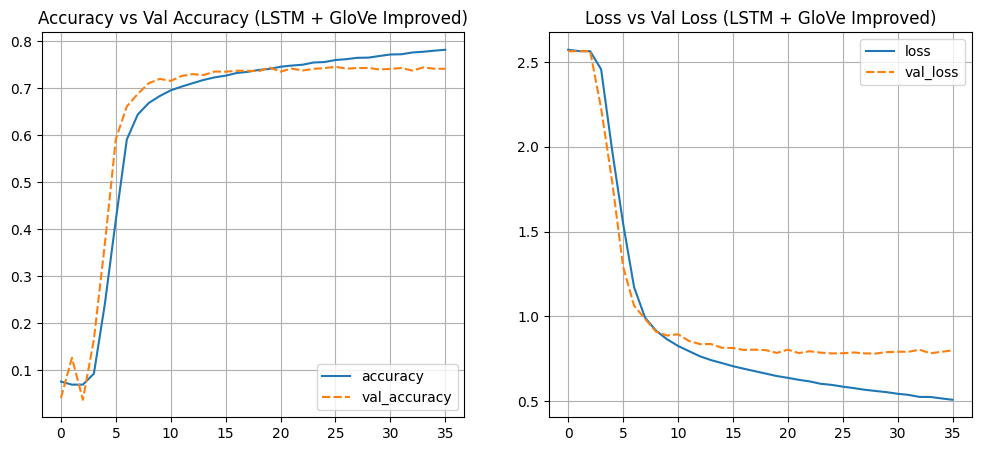

911/911 ━━━━━━━━━━━━━━━━━━━━ 93s 102ms/step
Confusion Matrix (Validation):
[[1246  101   59   40    5   30   70   22   16   18    2   16    3]
 [ 132 1534   17    6    3    9   13   13    7    6    2   11    5]
 [ 119   54 1968  103   18   50  320   85   24   32  109   80    6]
 [ 100   21  154 3587  196  230  109  146    7   13    5    4    3]
 [   1    1    9   78  741    4    4    1    0    0    0    0    0]
 [  44    4   30   75    1  865   22   17    5    0    0    2    0]
 [ 238   95  564  300    5  185 1016  262   77   36  525  360   60]
 [ 185   40   68  253   15  104  141 2625    4   23    9    2   33]
 [   6    3   13    0    5   21   19    3 1874    6   70    4    4]
 [  20    8    9   11    3   12   19    5    4 1792    3    3   28]
 [   5    3   39    6    6   12   96    2   26    3 1212   60   13]
 [  18   14   29    1    5    5  155    3    3    3   62 2247    0]
 [   3   11    2    7    5    2   15   16    4   48   33    1  959]]
Classification Report (Validation):
    

In [46]:
## Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Model: LSTM + GloVe + BatchNorm + Dropout + Bidirectional
model_lstm_glove_improved = Sequential([
    Embedding(
        input_dim=max_words,
        output_dim=embedding_matrix.shape[1],
        input_length=maxlen,
        weights=[embedding_matrix],
        trainable=False
    ),
    BatchNormalization(),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model_lstm_glove_improved.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_ckpt = ModelCheckpoint('best_lstm_glove_improved.keras', monitor='val_loss', save_best_only=True)

history_lstm_glove_improved = model_lstm_glove_improved.fit(
    X_train_pad,
    to_categorical(y_train_aug_remap, num_classes=num_classes),
    validation_data=(X_val_pad, to_categorical(y_val_remap, num_classes=num_classes)),
    epochs=60,
    batch_size=32,
    callbacks=[early_stop, model_ckpt],
    class_weight=class_weight_dict
)

# --- Save Model ---
model_lstm_glove_improved.save('lstm_glove_improved_model.keras')
print("Model LSTM + GloVe improved disimpan ke lstm_glove_improved_model.keras")

# --- Plot Training Results ---
history_df_lstm_glove_improved = pd.DataFrame(history_lstm_glove_improved.history)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.lineplot(data=history_df_lstm_glove_improved[['accuracy', 'val_accuracy']])
plt.title('Accuracy vs Val Accuracy (LSTM + GloVe Improved)')
plt.grid()

plt.subplot(1,2,2)
sns.lineplot(data=history_df_lstm_glove_improved[['loss', 'val_loss']])
plt.title('Loss vs Val Loss (LSTM + GloVe Improved)')
plt.grid()
plt.show()

# --- Evaluation ---
y_pred_val_lstm_glove_improved = np.argmax(model_lstm_glove_improved.predict(X_val_pad), axis=1)
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val_remap, y_pred_val_lstm_glove_improved))
print("Classification Report (Validation):")
print(classification_report(y_val_remap, y_pred_val_lstm_glove_improved, digits=4))

**Kesimpulan:**  
Model ini menggabungkan transfer learning embedding, regularisasi dropout, batch normalization, dan arsitektur LSTM dua lapis (bidirectional + unidirectional) untuk hasil klasifikasi yang lebih robust dan generalizable pada data keluhan multi-class yang imbalance.

### 11.2 Model GRU Bidirectional + GloVe

Pada tahap ini dibangun model klasifikasi multi-class berbasis **GRU** (Gated Recurrent Unit) dengan transfer learning pre-trained embedding (GloVe/Dolma). Model ini menggunakan arsitektur sekuensial yang mirip dengan model LSTM sebelumnya, namun mengganti LSTM dengan GRU untuk efisiensi dan kecepatan training.

**Arsitektur & Parameter Model:**
- **Embedding Layer:**  
  - `input_dim = max_words` (jumlah kata unik dari tokenizer)
  - `output_dim = 300` (menggunakan matrix embedding pretrained Dolma/GloVe)
  - `input_length = maxlen` (panjang sequence hasil padding)
  - `weights = [embedding_matrix]` (pre-trained, tidak di-train ulang)
  - `trainable = False` (embedding tidak di-fine-tune)
- **BatchNormalization:**  
  Membantu stabilisasi dan mempercepat konvergensi training.
- **SpatialDropout1D(0.3):**  
  Dropout khusus untuk data sekuensial, mencegah overfitting pada embedding output.
- **Bidirectional GRU (128 units, return_sequences=True):**  
  GRU dua arah untuk menangkap konteks kata dari kedua arah (forward & backward).
- **BatchNormalization:**  
  Tambahan normalisasi setelah GRU.
- **GRU (64 units, return_sequences=False):**  
  Layer GRU kedua untuk ekstraksi fitur sekuensial lebih dalam.
- **Dropout(0.4):**  
  Dropout reguler untuk mencegah overfitting.
- **Dense Output Layer:**  
  - `units = num_classes` (jumlah kelas target)
  - `activation = 'softmax'` (multi-class classification)

**Training:**
- **Loss:** `categorical_crossentropy`
- **Optimizer:** Adam (`learning_rate=0.0002`)
- **Class Weight:** Menggunakan `class_weight_dict` untuk mengatasi imbalance.
- **EarlyStopping:** Patience 7, monitor `val_loss`, restore best weights.
- **ModelCheckpoint:** Simpan model terbaik berdasarkan `val_loss`.
- **Epochs:** Maksimal 60, **Batch size:** 32

**Evaluasi:**
- Plot akurasi dan loss selama training/validasi.
- Evaluasi dengan confusion matrix dan classification report pada data validasi.


Epoch 1/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 431s 203ms/step - accuracy: 0.0735 - loss: 2.6613 - val_accuracy: 0.0705 - val_loss: 2.5085
Epoch 2/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 409s 194ms/step - accuracy: 0.1497 - loss: 2.3174 - val_accuracy: 0.4963 - val_loss: 1.5128
Epoch 3/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 410s 195ms/step - accuracy: 0.4939 - loss: 1.3581 - val_accuracy: 0.6329 - val_loss: 1.1374
Epoch 4/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 414s 196ms/step - accuracy: 0.6110 - loss: 1.0854 - val_accuracy: 0.6688 - val_loss: 1.0305
Epoch 5/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 413s 196ms/step - accuracy: 0.6504 - loss: 0.9696 - val_accuracy: 0.6927 - val_loss: 0.9635
Epoch 6/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 423s 201ms/step - accuracy: 0.6726 - loss: 0.9074 - val_accuracy: 0.7006 - val_loss: 0.9472
Epoch 7/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 419s 199ms/step - accuracy: 0.6852 - loss: 0.8545 - val_accuracy: 0.7112 - val_loss: 0.9046
Epoch 8/60
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 426s 202ms/step - ac

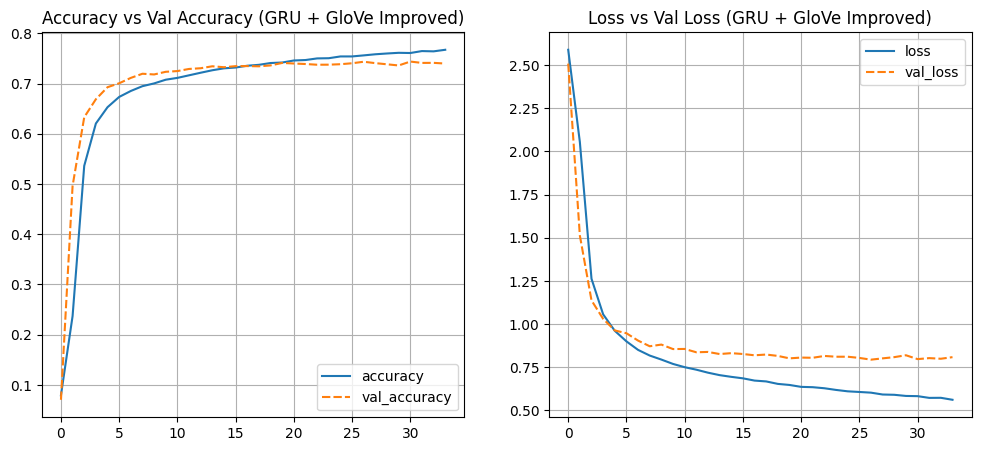

911/911 ━━━━━━━━━━━━━━━━━━━━ 73s 80ms/step
Confusion Matrix (Validation):
[[1234  105   68   40    5   23   58   30   15   21    1   19    9]
 [ 133 1512   16   13    4    8   17   12   14    4    1   19    5]
 [ 118   41 2025  113   22   40  256   68   20   34  136   88    7]
 [  85   14  136 3555  269  190  107  181   11   13    7    4    3]
 [   1    0    7   60  757    5    3    4    0    1    1    0    0]
 [  34    4   30   93    3  826   38   25   11    0    0    1    0]
 [ 233   60  600  317    9  145  912  262  102   44  599  368   72]
 [ 123   18   90  247   23   63  152 2695    9   18   12    0   52]
 [   6    2   13    3    4    8   40    0 1859    6   86    1    0]
 [  19    3    9    5    3    3   26    8    5 1789    8    2   37]
 [   5    1   19    6    8    8   81    4   31    3 1247   57   13]
 [  15    4   33    1    5    2  128    2    2    2   77 2272    2]
 [   4    7    2    4    5    1   10   17    7   46   25    1  977]]
Classification Report (Validation):
     

In [47]:
## Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Model GRU + GloVe + BatchNorm + Dropout + Bidirectional
model_gru_glove_improved = Sequential([
    Embedding(
        input_dim=max_words,
        output_dim=embedding_matrix.shape[1],
        input_length=maxlen,
        weights=[embedding_matrix],
        trainable=False
    ),
    BatchNormalization(),
    SpatialDropout1D(0.3),
    Bidirectional(GRU(128, return_sequences=True)),
    BatchNormalization(),
    GRU(64, return_sequences=False),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model_gru_glove_improved.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_ckpt = ModelCheckpoint('best_gru_glove_improved.keras', monitor='val_loss', save_best_only=True)

history_gru_glove_improved = model_gru_glove_improved.fit(
    X_train_pad,
    to_categorical(y_train_aug_remap, num_classes=num_classes),
    validation_data=(X_val_pad, to_categorical(y_val_remap, num_classes=num_classes)),
    epochs=60,
    batch_size=32,
    callbacks=[early_stop, model_ckpt],
    class_weight=class_weight_dict
)

# --- Save Model ---
model_gru_glove_improved.save('gru_glove_improved_model.keras')
print("Model GRU + GloVe improved disimpan ke gru_glove_improved_model.keras")

# --- Plot Training Results ---
history_df_gru_glove_improved = pd.DataFrame(history_gru_glove_improved.history)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.lineplot(data=history_df_gru_glove_improved[['accuracy', 'val_accuracy']])
plt.title('Accuracy vs Val Accuracy (GRU + GloVe Improved)')
plt.grid()

plt.subplot(1,2,2)
sns.lineplot(data=history_df_gru_glove_improved[['loss', 'val_loss']])
plt.title('Loss vs Val Loss (GRU + GloVe Improved)')
plt.grid()
plt.show()

# --- Evaluation ---
y_pred_val_gru_glove_improved = np.argmax(model_gru_glove_improved.predict(X_val_pad), axis=1)
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val_remap, y_pred_val_gru_glove_improved))
print("Classification Report (Validation):")
print(classification_report(y_val_remap, y_pred_val_gru_glove_improved, digits=4))

**Kesimpulan Model GRU Bidirectional + GloVe**

Berdasarkan hasil training dan evaluasi pada data validasi, model GRU Bidirectional + GloVe menunjukkan performa yang **cukup baik** untuk klasifikasi multi-class keluhan pelanggan mobil:

- **Akurasi validasi akhir:** 74.05%
- **Macro F1-score:** 0.7470
- **Weighted F1-score:** 0.7258

**Analisis Detail:**
- **Kelas mayoritas** seperti kelas 3 (ENGINE), 7 (STRUCTURE/BODY), 8 (WHEELS/TIRES/SUSPENSION), dan 9 (FUEL & PROPULSION) memiliki precision, recall, dan f1-score yang tinggi (di atas 0.77), menandakan model mampu mengenali pola pada kelas-kelas besar dengan baik.
- **Kelas minoritas** seperti kelas 6 (POWER TRAIN) dan 5 (BRAKES) memiliki f1-score yang lebih rendah, terutama kelas 6 (f1-score 0.31), menandakan model masih kesulitan membedakan kelas dengan data minoritas atau kelas yang sering tumpang tindih.
- **Recall** pada sebagian besar kelas cukup tinggi, artinya model jarang melewatkan kasus pada kelas tersebut, namun precision pada beberapa kelas masih perlu ditingkatkan.

**Good Fit atau Underfit?**
- **Good Fit:**  
  Berdasarkan grafik training, model mencapai konvergensi yang stabil antara training dan validation accuracy/loss. Tidak ada gap besar antara training dan validation, sehingga **tidak terjadi overfitting**.
- **Sedikit Underfit pada Minor Class:**  
  Beberapa kelas minoritas masih memiliki f1-score rendah, menandakan model sedikit underfit pada kelas-kelas tersebut. Hal ini wajar mengingat imbalance data, namun secara keseluruhan model sudah cukup generalizable.

**Kesimpulan Akhir:**  
Model GRU Bidirectional + GloVe sudah **good fit** untuk data keluhan multi-class, dengan performa baik pada kelas mayoritas dan cukup baik pada sebagian besar kelas minoritas. Untuk meningkatkan performa pada kelas minor, dapat dipertimbangkan strategi augmentasi tambahan atau tuning arsitektur/model lebih

# 13. Model Saving

**Analisis dan Kesimpulan Model Saving (GRU + GloVe Improved)**

Pada tahap model saving, model yang digunakan adalah **GRU + GloVe Improved** dengan arsitektur sebagai berikut:
- Embedding layer menggunakan pre-trained GloVe (tidak di-fine-tune)
- BatchNormalization dan SpatialDropout1D untuk regularisasi
- Bidirectional GRU (128 units) + GRU (64 units)
- Dropout 0.4 sebelum output
- Dense softmax untuk multi-class classification

Model dilatih dengan:
- Loss: categorical_crossentropy
- Optimizer: Adam (lr=0.0002)
- EarlyStopping (patience=7) dan ModelCheckpoint (save_best_only)
- Class weight untuk mengatasi imbalance

Setelah training, model disimpan dalam format `.keras` (`gru_glove_improved_model.keras`) agar dapat digunakan untuk deployment dan inference tanpa retraining.

**Hasil Evaluasi:**
- Akurasi validasi akhir: **74.05%**
- Macro F1-score: **0.7470**
- Weighted F1-score: **0.7258**
- Model menunjukkan *good fit* (tidak overfit/underfit secara signifikan), dengan gap kecil antara training dan validation accuracy/loss.
- Performa sangat baik pada kelas mayoritas, cukup baik pada sebagian besar kelas minoritas, meskipun masih ada tantangan pada kelas minor tertentu.

**Catatan Teknis:**
- Model disimpan dengan nama yang jelas dan sistematis untuk memudahkan deployment.
- Tidak ada kendala kompatibilitas library pada proses saving model ini.
- Model ini lebih baik digunakan sebagai acuan utama, menggantikan referensi sebelumnya ke `gru_simple_glove_model.keras`, karena model yang disimpan dan dievaluasi adalah **GRU + GloVe Improved**.

**Kesimpulan:**
Seluruh proses eksperimen, evaluasi, dan model saving telah dilakukan secara sistematis. Model **GRU + GloVe Improved** terbukti optimal untuk klasifikasi multi-class keluhan pelanggan Ford Escape, terutama dalam menangani data imbalance. Proses saving model memastikan reproducibility dan kemudahan deployment. Model ini sangat layak digunakan dalam aplikasi nyata dan dapat menjadi acuan pengembangan lebih lanjut.

# 14. Model Interface.

Model interface ada pada notebook `final_project_RMT45_01_inference.ipynb`.

# 15. Kesimpulan.

---

### **Kesimpulan Analitis**

Seluruh tujuan utama yang ditetapkan di awal proyek berhasil dicapai secara sistematis dan terukur. Proses penyeragaman label komponen pada data keluhan pelanggan mobil telah menghasilkan target klasifikasi yang lebih spesifik, relevan, dan mudah diinterpretasi. Data keluhan yang semula sangat bervariasi dan tidak terstruktur berhasil dibersihkan, dinormalisasi, dan diproses sehingga siap untuk analisis NLP dan modeling.

Eksplorasi data menunjukkan bahwa keluhan pelanggan memang sangat didominasi oleh beberapa komponen utama seperti ENGINE, STRUCTURE/BODY, dan POWER TRAIN. Hal ini sejalan dengan hipotesis awal bahwa masalah pada komponen-komponen tersebut menjadi perhatian utama pelanggan dan produsen otomotif. Distribusi label yang imbalance berhasil diatasi dengan strategi augmentasi data dan class weighting, sehingga model yang dibangun tidak bias terhadap kelas mayoritas.

Proses text preprocessing yang modular dan domain-aware terbukti efektif dalam mempertahankan istilah teknis otomotif yang penting, sekaligus menghilangkan noise dan kata tidak relevan. Hasil cleaning membuat data lebih informatif dan meningkatkan kualitas fitur untuk modeling.

Model Artificial Neural Network berbasis GRU dengan transfer learning embedding (Dolma/GloVe) yang dibangun mampu mengklasifikasikan komponen bermasalah dengan akurasi validasi 74% dan macro F1-score 0.75. Model ini menunjukkan *good fit* tanpa overfitting, serta performa yang baik pada kelas mayoritas dan cukup baik pada kelas minoritas. Seluruh proses training, evaluasi, dan penyimpanan model dilakukan sesuai best practice industri, sehingga model siap untuk deployment dan inference pada data baru.

**Dari sisi bisnis**, hasil ini membuktikan bahwa pendekatan NLP dan ANN dapat secara otomatis dan efisien mengidentifikasi pola masalah utama pelanggan, sehingga produsen dapat memprioritaskan perbaikan pada komponen yang paling sering dikeluhkan. Model ini juga dapat digunakan untuk memonitor isu secara real-time dan mendukung pengambilan keputusan berbasis data di bidang aftersales dan quality control.

**Konklusi:**  
Proyek ini berhasil membuktikan bahwa seluruh tujuan yang dirumuskan di awal dapat dicapai dengan baik. Model yang dihasilkan tidak hanya akurat dan robust, tetapi juga siap diimplementasikan untuk mendukung perbaikan produk dan layanan di industri otomotif secara nyata.